# Neural network for h->aa->bbtautau signal/background separation

# Model definition and training

## Packages

In [1]:
import ROOT
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Activation, Dense, Dropout
from keras.initializers import glorot_uniform
from keras.utils import plot_model

import kerastuner
from kerastuner import Hyperband

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

import joblib

Welcome to JupyROOT 6.22/06


Using TensorFlow backend.


## Load root files

In [2]:
file_obs18 = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/data_obs.root')
file_sig18 = ROOT.RDataFrame('emu_tree', {'root_raw/em18_raw/ggH_bbtt*.root', 'root_raw/em18_raw/vbf_bbtt*.root'})
file_ZTT18 = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/embedded.root')
file_TT18 = ROOT.RDataFrame('emu_tree', 'root_raw/em18_raw/TT*.root')

file_obs17 = ROOT.RDataFrame('emu_tree', 'root_raw/em17_raw/data_obs.root')
file_sig17 = ROOT.RDataFrame('emu_tree',  {'root_raw/em17_raw/ggH_bbtt*.root', 'root_raw/em17_raw/vbf_bbtt*.root'})
file_ZTT17 = ROOT.RDataFrame('emu_tree', 'root_raw/em17_raw/embedded.root')
file_TT17 = ROOT.RDataFrame('emu_tree', 'root_raw/em17_raw/TT*.root')

file_obs16 = ROOT.RDataFrame('emu_tree', 'root_raw/em16_raw/data_obs.root')
file_sig16 = ROOT.RDataFrame('emu_tree', {'root_raw/em16_raw/ggH_bbtt*.root', 'root_raw/em16_raw/vbf_bbtt*.root'})
file_ZTT16 = ROOT.RDataFrame('emu_tree', 'root_raw/em16_raw/embedded.root')
file_TT16 = ROOT.RDataFrame('emu_tree', 'root_raw/em16_raw/TT*.root')

files18 = [file_obs18, file_sig18, file_ZTT18, file_TT18]
files17 = [file_obs17, file_sig17, file_ZTT17, file_TT17]
files16 = [file_obs16, file_sig16, file_ZTT16, file_TT16]

In [3]:
# 2b events
for i in range(len(files18)):
    files18[i] = files18[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4184').Filter('bpt_deepcsv_2>20 && bscore_deepcsv_2>0.4184')
    files17[i] = files17[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.4941').Filter('bpt_deepcsv_2>20 && bscore_deepcsv_2>0.4941')
    files16[i] = files16[i].Filter('bpt_deepcsv_1>20 && bscore_deepcsv_1>0.6321').Filter('bpt_deepcsv_2>20 && bscore_deepcsv_2>0.6321')

## Define some input features

In [4]:
# define 4-vectors, invariant masses and etc.
myele = 'ROOT::Math::PtEtaPhiMVector(pt_1,eta_1,phi_1,m_1)'
mymu = 'ROOT::Math::PtEtaPhiMVector(pt_2,eta_2,phi_2,m_2)'
mymet = 'ROOT::Math::PtEtaPhiMVector(met,0,metphi,0)'
mytt = 'ROOT::Math::PtEtaPhiMVector((myele+mymu+mymet).Pt(),(myele+mymu+mymet).Eta(),(myele+mymu+mymet).Phi(),m_sv)'
myb1 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_1,beta_deepcsv_1,bphi_deepcsv_1,bm_deepcsv_1)'
myb2 = 'ROOT::Math::PtEtaPhiMVector(bpt_deepcsv_2,beta_deepcsv_2,bphi_deepcsv_2,bm_deepcsv_2)'
m_b1tt = '(mytt+myb1).M()'
m_b2tt = '(mytt+myb2).M()'
m_bbtt = '(mytt+myb1+myb2).M()'
m_bb = '(myb1+myb2).M()'
m_b1ele = '(myele+myb1).M()'
m_b1mu = '(mymu+myb1).M()'
m_b2ele = '(myele+myb2).M()'
m_b2mu = '(mymu+myb2).M()'
m_bbele = '(myb1+myb2+myele).M()'
m_bbmu = '(myb1+myb2+mymu).M()'
dm_a = '(m_bb-m_sv)/m_sv'
dR_tt = 'ROOT::Math::VectorUtil::DeltaR(myele,mymu)'
dR_b1ele = 'ROOT::Math::VectorUtil::DeltaR(myele,myb1)'
dR_b1mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb1)'
dR_b2ele = 'ROOT::Math::VectorUtil::DeltaR(myele,myb2)'
dR_b2mu = 'ROOT::Math::VectorUtil::DeltaR(mymu,myb2)'
dR_bb = 'ROOT::Math::VectorUtil::DeltaR(myb1,myb2)'
dR_b1tt = 'ROOT::Math::VectorUtil::DeltaR(myb1,mytt)'
dR_b2tt = 'ROOT::Math::VectorUtil::DeltaR(myb2,mytt)'
dR_bbele = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,myele)'
dR_bbmu = 'ROOT::Math::VectorUtil::DeltaR(myb1+myb2,mymu)'
dR_aa = 'ROOT::Math::VectorUtil::DeltaR(mytt,myb1+myb2)'

# define transverse masses mT and D_zeta
mT_ele = 'sqrt(pow(myele.Pt()+mymet.Pt(),2)-pow(myele.Px()+mymet.Px(),2)-pow(myele.Py()+mymet.Py(),2))'
mT_mu = 'sqrt(pow(mymu.Pt()+mymet.Pt(),2)-pow(mymu.Px()+mymet.Px(),2)-pow(mymu.Py()+mymet.Py(),2))'
mT_b1 = 'sqrt(pow(myb1.Pt()+mymet.Pt(),2)-pow(myb1.Px()+mymet.Px(),2)-pow(myb1.Py()+mymet.Py(),2))'
mT_b2 = 'sqrt(pow(myb2.Pt()+mymet.Pt(),2)-pow(myb2.Px()+mymet.Px(),2)-pow(myb2.Py()+mymet.Py(),2))'
norm_zeta = 'sqrt(pow(myele.Px()/myele.Pt()+mymu.Px()/mymu.Pt(),2)+pow(myele.Py()/myele.Pt()+mymu.Py()/mymu.Pt(),2))'
x_zeta = '(myele.Px()/myele.Pt()+mymu.Px()/mymu.Pt())/norm_zeta'
y_zeta = '(myele.Py()/myele.Pt()+mymu.Py()/mymu.Pt())/norm_zeta'
p_zeta_mis = 'mymet.Px()*x_zeta+mymet.Py()*y_zeta'
pzeta_vis = '(myele.Px()+mymu.Px())*x_zeta+(myele.Py()+mymu.Py())*y_zeta'
Dzeta = 'p_zeta_mis-0.85*pzeta_vis'

# add defined variables to dataframe
for i in range(len(files18)):
    files18[i] = files18[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbmu', m_bbmu)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files17[i] = files17[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbmu', m_bbmu)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)
    
    files16[i] = files16[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbmu', m_bbmu)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Apply baseline selection cuts

In [5]:
######################## 2 0 1 8 ##########################
# 2018 ele+mu trigger requirements
trigger823_18 = '(passMu8E23DZ && matchMu8E23DZ_1 && filterMu8E23DZ_1 && matchMu8E23DZ_2 && filterMu8E23DZ_2 && pt_1>24 && pt_2>13)'
trigger2312_18 = '(passMu23E12DZ && matchMu23E12DZ_1 && filterMu23E12DZ_1 && matchMu23E12DZ_2 && filterMu23E12DZ_2 && pt_1>13 && pt_2>24)'

trigger_all_18 = trigger823_18 + str(' or ') + trigger2312_18

for i in range(len(files18)):
    files18[i] = files18[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('fabs(eta_1)<2.4 && fabs(eta_2)<2.4')\
    .Filter('dR_tt>0.3')

files18[0] = files18[0].Filter('Flag_eeBadScFilter==0')
files18[2] = files18[2].Filter('Flag_eeBadScFilter==0')

files18[3] = files18[3].Filter('!(gen_match_1>2 && gen_match_1<6 && gen_match_2>2 && gen_match_2<6)')

files18[1] = files18[1].Filter('gen_match_1==3 && gen_match_2==4')#recontructed taus are gen taus
files18[1] = files18[1].Filter('m_b1tt<200').Filter('m_bbtt<400 && dm_a<2')#reject long tail (mostly wrongly reco b jet)

# triggers
files18[0] = files18[0].Filter(trigger_all_18).Filter('iso_1<0.3 && iso_2<0.3')
files18[1] = files18[1].Filter(trigger_all_18).Filter('iso_1<0.15 && iso_2<0.15')
files18[2] = files18[2].Filter(trigger_all_18).Filter('iso_1<0.15 && iso_2<0.15')
files18[3] = files18[3].Filter(trigger_all_18).Filter('iso_1<0.15 && iso_2<0.15')

# QCD region
qcd_18 = files18[0].Filter('q_1*q_2>0').Filter('gen_match_1<6 && gen_match_2<6')

# signal region
for i in range(1,len(files18)):
    files18[i] = files18[i].Filter('q_1*q_2<0')

######################## 2 0 1 7 ##########################
# 2017 ele+mu trigger requirements 
trigger823_17 = '(passMu8E23DZ && matchMu8E23DZ_1 && filterMu8E23DZ_1 && matchMu8E23DZ_2 && filterMu8E23DZ_2 && pt_1>24 && pt_2>13)'
trigger2312_17 = '(passMu23E12DZ && matchMu23E12DZ_1 && filterMu23E12DZ_1 && matchMu23E12DZ_2 && filterMu23E12DZ_2 && pt_1>13 && pt_2>24)'

trigger_all_17 = trigger823_17 + str(' or ') + trigger2312_17

for i in range(len(files17)):
    files17[i] = files17[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('Flag_ecalBadCalibReducedMINIAODFilter==0')\
    .Filter('fabs(eta_1)<2.4 && fabs(eta_2)<2.4')\
    .Filter('dR_tt>0.3')

files17[0] = files17[0].Filter('Flag_eeBadScFilter==0')
files17[2] = files17[2].Filter('Flag_eeBadScFilter==0')

files17[3] = files17[3].Filter('!(gen_match_1>2 && gen_match_1<6 && gen_match_2>2 && gen_match_2<6)')

files17[1] = files17[1].Filter('gen_match_1==3 && gen_match_2==4')#recontructed taus are gen taus
files17[1] = files17[1].Filter('m_b1tt<200').Filter('m_bbtt<400 && dm_a<2')#reject long tail (mostly wrongly reco b jet)

# triggers
files17[0] = files17[0].Filter(trigger_all_17).Filter('iso_1<0.3 && iso_2<0.3')
files17[1] = files17[1].Filter(trigger_all_17).Filter('iso_1<0.15 && iso_2<0.15')
files17[2] = files17[2].Filter(trigger_all_17).Filter('iso_1<0.15 && iso_2<0.15')
files17[3] = files17[3].Filter(trigger_all_17).Filter('iso_1<0.15 && iso_2<0.15')

# QCD region
qcd_17 = files17[0].Filter('q_1*q_2>0').Filter('gen_match_1<6 && gen_match_2<6')

# signal region
for i in range(1,len(files17)):
    files17[i] = files17[i].Filter('q_1*q_2<0')

######################## 2 0 1 6 ##########################
# 2016 ele+mu trigger requirements
trigger823_16 = '(passMu8E23 && matchMu8E23_1 && filterMu8E23_1 && matchMu8E23_2 && pt_1>24 && pt_2>13)'
trigger2312_16 = '(passMu23E12 && matchMu23E12_1 && filterMu23E12_1 && matchMu23E12_2 && pt_1>13 && pt_2>24)'

trigger_all_16 = trigger823_16 + str(' or ') + trigger2312_16

for i in range(len(files16)):
    files16[i] = files16[i].Filter('Flag_goodVertices==0')\
    .Filter('Flag_globalSuperTightHalo2016Filter==0')\
    .Filter('Flag_HBHENoiseFilter==0')\
    .Filter('Flag_HBHENoiseIsoFilter==0')\
    .Filter('Flag_EcalDeadCellTriggerPrimitiveFilter==0')\
    .Filter('Flag_BadPFMuonFilter==0')\
    .Filter('fabs(eta_1)<2.4 && fabs(eta_2)<2.4')\
    .Filter('dR_tt>0.3')

files16[0] = files16[0].Filter('Flag_eeBadScFilter==0')
files16[2] = files16[2].Filter('Flag_eeBadScFilter==0')

files16[3] = files16[3].Filter('!(gen_match_1>2 && gen_match_1<6 && gen_match_2>2 && gen_match_2<6)')

files16[1] = files16[1].Filter('gen_match_1==3 && gen_match_2==4')#recontructed taus are gen taus
files16[1] = files16[1].Filter('m_b1tt<200').Filter('m_bbtt<400 && dm_a<2')#reject long tail (mostly wrongly reco b jet)

files16[2] = files16[2].Filter('genweight<=1.0')

# triggers
files16[0] = files16[0].Filter(trigger_all_16).Filter('iso_1<0.3 && iso_2<0.3')
files16[1] = files16[1].Filter(trigger_all_16).Filter('iso_1<0.15 && iso_2<0.15')
files16[2] = files16[2].Filter(trigger_all_16).Filter('iso_1<0.15 && iso_2<0.15')
files16[3] = files16[3].Filter(trigger_all_16).Filter('iso_1<0.15 && iso_2<0.15')

# QCD region
qcd_16 = files16[0].Filter('q_1*q_2>0').Filter('gen_match_1<6 && gen_match_2<6')

# signal region
for i in range(1,len(files16)):
    files16[i] = files16[i].Filter('q_1*q_2<0')

# [0]=obs, [1]=sig, [2]=embedded, [3]=ttbar

## Select all input features and save into pandas DataFrame

In [6]:
# list of feature variables
###### for 2b events
feature_list = ['pt_1', 'pt_2', 'm_b1tt', 'm_b2tt', 'm_bbtt', 'm_bb', 'm_b1ele', 'm_b1mu', 'm_b2ele', 'm_b2mu', 'dm_a',\
                'm_bbele', 'm_bbmu', 'dR_tt', 'dR_b1ele', 'dR_b1mu', 'dR_b2ele', 'dR_b2mu', 'dR_bb', 'dR_b1tt', 'dR_b2tt', 'dR_aa',\
                'dR_bbele','dR_bbmu', 'mT_ele', 'mT_mu', 'mT_b1', 'mT_b2', 'Dzeta',\
                'bpt_deepcsv_1', 'bpt_deepcsv_2']

# convert root RDataFrame into pandas DataFrame, saving only the features as columns
for i in range(1,len(files18)):
    files18[i] = pd.DataFrame(files18[i].AsNumpy(feature_list))
    files17[i] = pd.DataFrame(files17[i].AsNumpy(feature_list))
    files16[i] = pd.DataFrame(files16[i].AsNumpy(feature_list))
qcd_18 = pd.DataFrame(qcd_18.AsNumpy(feature_list))
qcd_17 = pd.DataFrame(qcd_17.AsNumpy(feature_list))
qcd_16 = pd.DataFrame(qcd_16.AsNumpy(feature_list))

print('sig18.shape  : ' + str(files18[1].shape))
print('ZTT18.shape  : ' + str(files18[2].shape))
print('TT18.shape   : ' + str(files18[3].shape))
print('qcd18.shape: ' + str(qcd_18.shape))
print('\nsig17.shape  : ' + str(files17[1].shape))
print('ZTT17.shape  : ' + str(files17[2].shape))
print('TT17.shape   : ' + str(files17[3].shape))
print('qcd17.shape  : ' + str(qcd_17.shape))
print('\nsig16.shape  : ' + str(files16[1].shape))
print('ZTT16.shape  : ' + str(files16[2].shape))
print('TT16.shape   : ' + str(files16[3].shape))
print('qcd16.shape  : ' + str(qcd_16.shape))

sig_allyears = [files18[1], files17[1], files16[1]]
ZTT_allyears = [files18[2], files17[2], files16[2]]
TT_allyears = [files18[3], files17[3], files16[3]]
qcd_allyears = [qcd_18, qcd_17, qcd_16]

sig_allyears = pd.concat(sig_allyears)
ZTT_allyears = pd.concat(ZTT_allyears)
TT_allyears = pd.concat(TT_allyears)
qcd_allyears = pd.concat(qcd_allyears)

# tag MC signal events as class 1
sig_allyears['label'] = np.ones((sig_allyears.shape[0], 1))

# tag MC background events as class 0
ZTT_allyears['label'] = np.zeros((ZTT_allyears.shape[0], 1))
TT_allyears['label'] = np.zeros((TT_allyears.shape[0],1))
qcd_allyears['label'] = np.zeros((qcd_allyears.shape[0], 1))

print('\nsig_allyears.shape: ' + str(sig_allyears.shape))
print('ZTT_allyears.shape: ' + str(ZTT_allyears.shape))
print('TT_allyears.shape : ' + str(TT_allyears.shape))
print('qcd_allyears.shape: ' + str(qcd_allyears.shape))

sig18.shape  : (2365, 31)
ZTT18.shape  : (43620, 31)
TT18.shape   : (2591645, 31)
qcd18.shape: (4007, 31)

sig17.shape  : (2260, 31)
ZTT17.shape  : (33385, 31)
TT17.shape   : (357956, 31)
qcd17.shape  : (2261, 31)

sig16.shape  : (2763, 31)
ZTT16.shape  : (18082, 31)
TT16.shape   : (271605, 31)
qcd16.shape  : (1388, 31)

sig_allyears.shape: (7388, 32)
ZTT_allyears.shape: (95087, 32)
TT_allyears.shape : (3221206, 32)
qcd_allyears.shape: (7656, 32)


## Split into MC/data

In [7]:
# reduce class 0 sample size for balanced training
ZTT_allyears = ZTT_allyears.sample(n = 52, random_state = 20)#1156->0.7%->
TT_allyears = TT_allyears.sample(n = 7277, random_state = 20)#163286->98.5%->
qcd_allyears = qcd_allyears.sample(n = 59, random_state = 20)#1402->0.8%->

# collect all MC as one dataframe, separated from another datafream for observed data
df_bkg = [ZTT_allyears, TT_allyears, qcd_allyears]
df_bkg = pd.concat(df_bkg)

df_MC = [sig_allyears, ZTT_allyears, TT_allyears, qcd_allyears]
df_MC = pd.concat(df_MC)

#print('\nObserved dataframe: \n' + str(df_obs))
print('\nMC dataframe: \n' + str(df_MC))


MC dataframe: 
            pt_1       pt_2      m_b1tt      m_b2tt      m_bbtt        m_bb  \
0      16.843185  30.743385  124.310345   92.143582  155.153848   22.400262   
1      15.085020  28.112827   82.088402  143.990720  171.027931   45.355881   
2      27.653637  19.061323   75.002939  104.091505  128.935558   23.095415   
3      31.361395  14.490415   68.352318   73.001005  103.160343   29.584692   
4      18.210991  24.075329  140.784255  101.929813  174.362332   21.221313   
...          ...        ...         ...         ...         ...         ...   
1374   24.295610  24.012901  358.026145  305.508953  460.905393  107.718713   
2812  180.708176  66.366310  267.903483  307.528662  395.491730  154.127057   
1920  129.374130  93.129448  841.063509  626.204494  902.355611  226.310016   
3685  105.373489  28.093050  609.259530  693.886728  727.721333   88.221639   
1545   42.236225  33.616058  282.321252  241.727518  308.967212   53.692185   

         m_b1ele      m_b1mu     m_

## Compare input feature distributions between sig and bkg

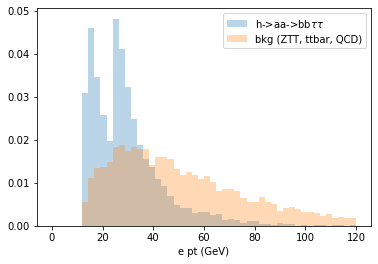

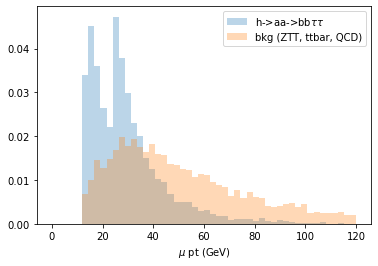

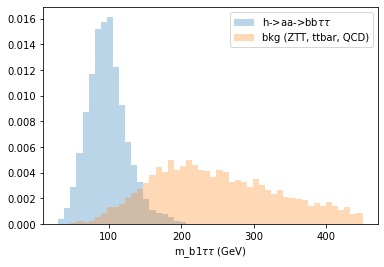

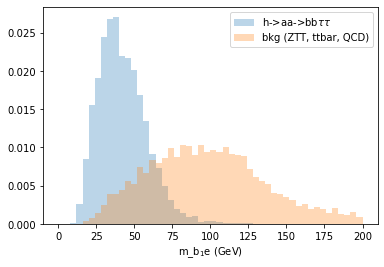

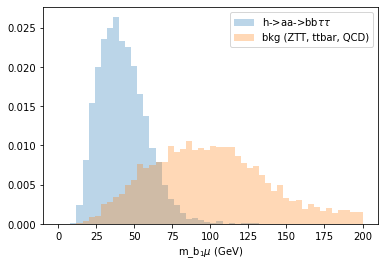

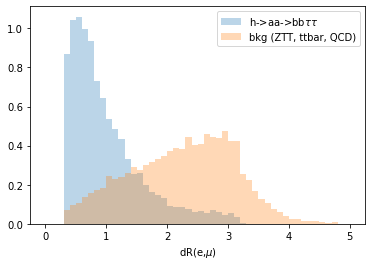

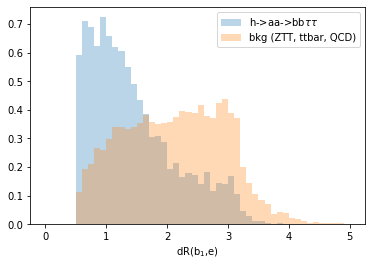

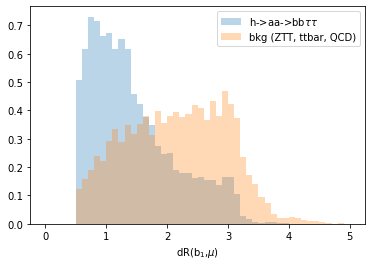

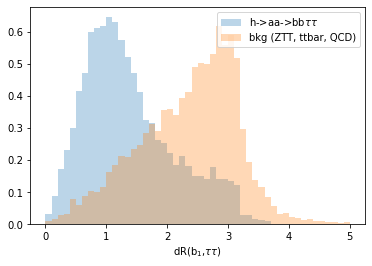

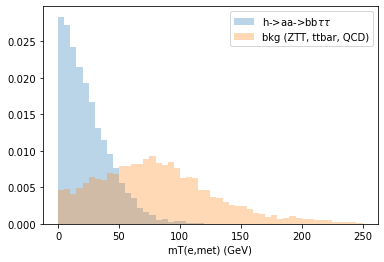

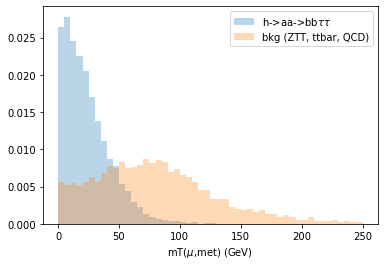

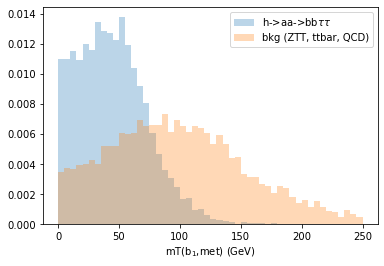

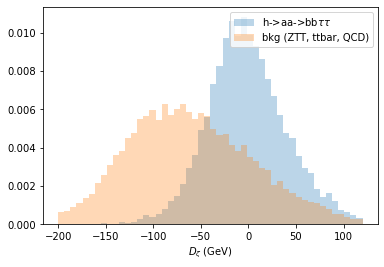

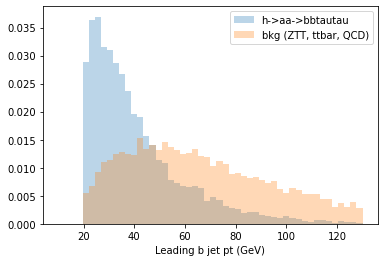

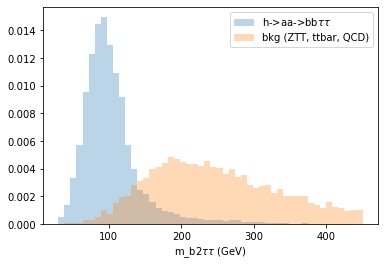

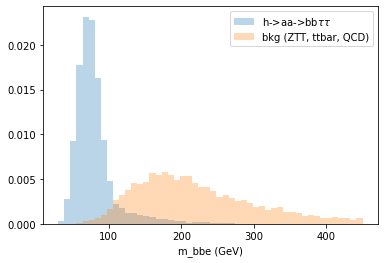

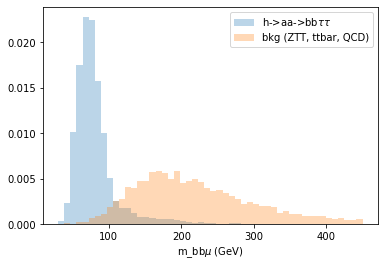

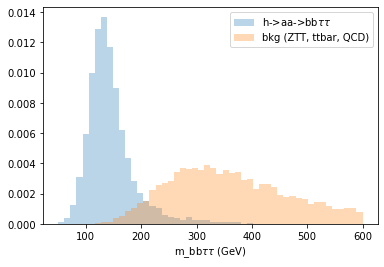

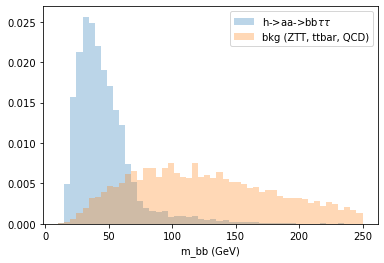

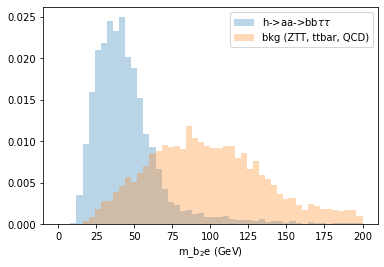

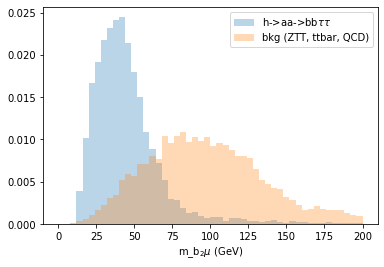

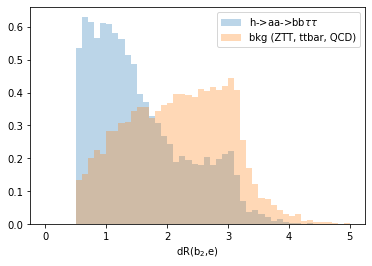

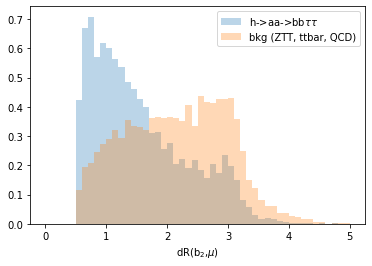

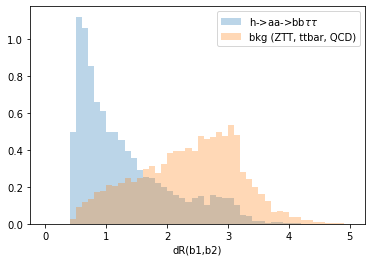

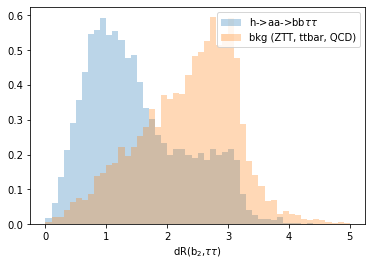

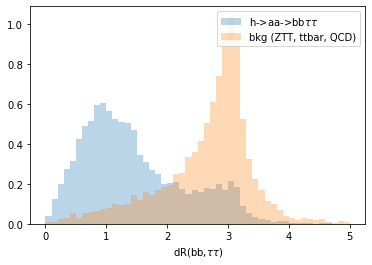

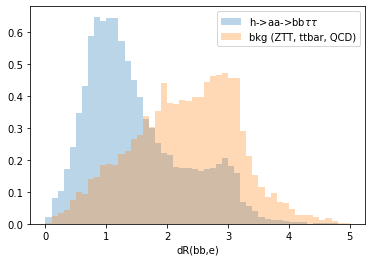

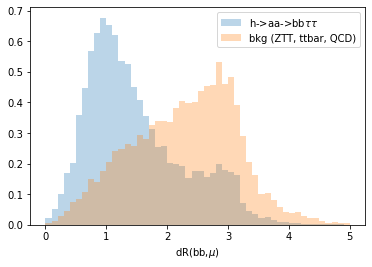

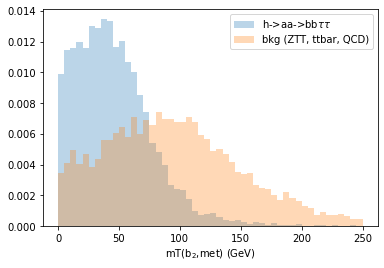

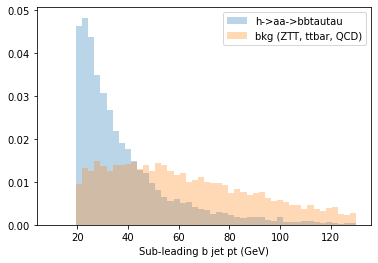

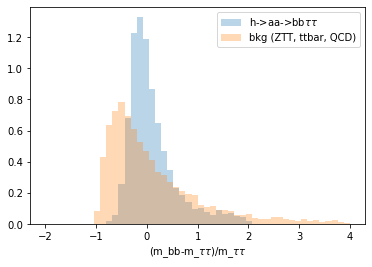

In [8]:
pyplot.hist(sig_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_1'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('e pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['pt_2'], density = 1, range = (0,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$\mu$ pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_btt'], density = 1, range = (30,450), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b1$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1ele'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$e (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['m_b1mu'], density = 1, range = (0,200), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_1$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(e,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1ele'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1mu'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['dR_b1tt'], density = 1, range = (0,5), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_1$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_ele'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(e,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_mu'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT($\mu$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['mT_b1'], density = 1, range = (0,250), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_1$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['Dzeta'], density = 1, range = (-200,120), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('$D_\zeta$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
#pyplot.hist(ZTT_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ZTT', histtype = 'step')
#pyplot.hist(TT_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'ttbar', histtype = 'step')
#pyplot.hist(qcd_allyears['bpt_deepcsv_1'], density = 1, range = (10,130), bins = 50, alpha = 1.0, label = 'QCD', histtype = 'step')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Leading b jet pt (GeV)')
pyplot.show()

############## for 2b events
pyplot.hist(sig_allyears['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2tt'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b2$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbele'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbele'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bbe (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbmu'], density = 1, range = (30,450), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bbtt'], density = 1, range = (50,600), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb$\\tau\\tau$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_bb'], density = 1, range = (10,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_bb (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2ele'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$e (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['m_b2mu'], density = 1, range = (0,200), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('m_b$_2$$\mu$ (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2ele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2mu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bb'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b1,b2)')
pyplot.show()

pyplot.hist(sig_allyears['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_b2tt'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(b$_2$,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_aa'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\\tau\\tau$)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbele'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,e)')
pyplot.show()

pyplot.hist(sig_allyears['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dR_bbmu'], density = 1, range = (0,5), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('dR(bb,$\mu$)')
pyplot.show()

pyplot.hist(sig_allyears['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['mT_b2'], density = 1, range = (0,250), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('mT(b$_2$,met) (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'h->aa->bbtautau')
pyplot.hist(df_bkg['bpt_deepcsv_2'], density = 1, range = (10,130), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('Sub-leading b jet pt (GeV)')
pyplot.show()

pyplot.hist(sig_allyears['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'h->aa->bb$\\tau\\tau$')
pyplot.hist(df_bkg['dm_a'], density = 1, range = (-2,4), bins = 50, alpha = 0.3, label = 'bkg (ZTT, ttbar, QCD)')
pyplot.legend(loc = 'upper right')
pyplot.xlabel('(m_bb-m_$\\tau\\tau$)/m_$\\tau\\tau$')
pyplot.show()

## Input data pre-processing

In [9]:
# convert to numpy arrays
dataset = df_MC.values
X = dataset[:,0:(dataset.shape[1]-1)]
Y = dataset[:,dataset.shape[1]-1]
Y = Y.reshape(Y.shape[0],1)

#dataset_obs = df_obs.values
#X_obs = dataset_obs[:,0:(dataset_obs.shape[1])]

# give train/val/test partition ratios
train_ratio = 0.5
val_ratio = 0.25
test_ratio = 1 - train_ratio - val_ratio

# randomly partition data set into train/val/test sets with given ratios
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size = test_ratio, random_state=15)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size = val_ratio/(val_ratio+train_ratio), random_state=15)

# standardize feature variables
# only based on means and stds in train_val set, should apply this only scaler to all other sets
# think of the transformation in phase space
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
#X_obs = scaler.transform(X_obs)

# print input data shapes
print("\nPartition the data set into train/val/test: %.2f/%.2f/%.2f" % (train_ratio, val_ratio, test_ratio))
print("X_train.shape: " + str(X_train.shape))
print("Y_train.shape: " + str(Y_train.shape))
print("X_val.shape: " + str(X_val.shape))
print("Y_val.shape: " + str(Y_val.shape))
print("X_test.shape: " + str(X_test.shape))
print("Y_test.shape: " + str(Y_test.shape))
#print("\nX_obs.shape: " + str(X_obs.shape))

# print ratio of signal/background examples in each set
train_sig = np.count_nonzero(Y_train)
train_bkg = np.count_nonzero(Y_train == 0)
train_sig_perc = 100*train_sig/(train_sig+train_bkg)
train_bkg_perc = 100*train_bkg/(train_sig+train_bkg)
val_sig = np.count_nonzero(Y_val)
val_bkg = np.count_nonzero(Y_val == 0)
val_sig_perc = 100*val_sig/(val_sig+val_bkg)
val_bkg_perc = 100*val_bkg/(val_sig+val_bkg)
test_sig = np.count_nonzero(Y_test)
test_bkg = np.count_nonzero(Y_test == 0)
test_sig_perc = 100*test_sig/(test_sig+test_bkg)
test_bkg_perc = 100*test_bkg/(test_sig+test_bkg)

total_sig = train_sig + val_sig + test_sig
total_bkg = train_bkg + val_bkg + test_bkg
total_sig_perc = 100*total_sig/(total_sig+total_bkg)
total_bkg_perc = 100*total_bkg/(total_sig+total_bkg)
print("\nTotal number of sig/bkg examples: %d/%d (%.2f%%/%.2f%%)" % (total_sig, total_bkg, total_sig_perc, total_bkg_perc))

print("\nNumber of sig/bkg examples in each set:")
print("train : %d/%d (%.1f%%/%.1f%%)" % (train_sig, train_bkg, train_sig_perc, train_bkg_perc))
print("val   : %d/%d (%.1f%%/%.1f%%)" % (val_sig, val_bkg, val_sig_perc, val_bkg_perc))
print("test  : %d/%d (%.1f%%/%.1f%%)" % (test_sig, test_bkg, test_sig_perc, test_bkg_perc))


Partition the data set into train/val/test: 0.50/0.25/0.25
X_train.shape: (7388, 31)
Y_train.shape: (7388, 1)
X_val.shape: (3694, 31)
Y_val.shape: (3694, 1)
X_test.shape: (3694, 31)
Y_test.shape: (3694, 1)

Total number of sig/bkg examples: 7388/7388 (50.00%/50.00%)

Number of sig/bkg examples in each set:
train : 3720/3668 (50.4%/49.6%)
val   : 1827/1867 (49.5%/50.5%)
test  : 1841/1853 (49.8%/50.2%)


## DNN Hyperparameters searching

In [10]:
# define model for the search
def hypermodel(hp):
    hp_model = keras.Sequential()
    hp_model.add(keras.layers.Input(shape = (X.shape[1],)))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_1',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_1',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))
    
    hp_model.add(keras.layers.Dense(units = hp.Int('units_2',
                                                   min_value = 30,
                                                   max_value = 70,
                                                   step = 2),
                                    activation = 'relu',
                                    kernel_initializer = glorot_uniform(seed=1)))
    
    hp_model.add(keras.layers.Dropout(rate = hp.Float('rate_2',
                                                      min_value = 0.2,
                                                      max_value = 0.5,
                                                      default = 0.2,
                                                      step = 0.1),
                                      seed = 10))

    hp_model.add(keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer = glorot_uniform(seed=1)))
    hp_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return hp_model

In [11]:
# define tuner model
tuner = Hyperband(hypermodel,
                  objective = 'val_accuracy',
                  max_epochs = 20,
                  factor = 3, #number of models to train in a bracket = 1+log_factor(max_epochs)
                  hyperband_iterations = 3, #number of times to iterate over the full Hyperband algorithm
                  seed = 10,
                  directory = 'hypertuning',
                  project_name = 'tune',
                  overwrite = True)

2021-04-13 20:45:50.931429: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-04-13 20:45:50.931817: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [12]:
# run the search
tuner.search(X_train, Y_train, epochs = 20, validation_data = (X_val,Y_val), batch_size = 128)

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 37s - loss: 0.9795 - accuracy: 0.445 - ETA: 3s - loss: 0.7399 - accuracy: 0.603 - ETA: 1s - loss: 0.5974 - accuracy: 0.71 - ETA: 0s - loss: 0.5056 - accuracy: 0.77 - ETA: 0s - loss: 0.4341 - accuracy: 0.81 - ETA: 0s - loss: 0.3844 - accuracy: 0.84 - ETA: 0s - loss: 0.3424 - accuracy: 0.86 - 1s 161us/sample - loss: 0.3395 - accuracy: 0.8623 - val_loss: 0.1123 - val_accuracy: 0.9656
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.95 - ETA: 0s - loss: 0.1419 - accuracy: 0.95 - ETA: 0s - loss: 0.1316 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.96 - ETA: 0s - loss: 0.1162 - accuracy: 0.96 - ETA: 0s - loss: 0.1115 - accuracy: 0.96 - 0s 60us/sample - loss: 0.1094 - accuracy: 0.9655 - val_loss: 0.0688 - val_accuracy: 0.9751
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.7264 - accuracy: 0.523 - ETA: 2s - loss: 0.6669 - accuracy: 0.558 - ETA: 1s - loss: 0.5954 - accuracy: 0.63 - ETA: 0s - loss: 0.5382 - accuracy: 0.70 - ETA: 0s - loss: 0.4856 - accuracy: 0.75 - ETA: 0s - loss: 0.4445 - accuracy: 0.78 - 1s 136us/sample - loss: 0.4295 - accuracy: 0.7956 - val_loss: 0.1701 - val_accuracy: 0.9561
Epoch 2/3
7388/7388 [==============================] - ETA: 3s - loss: 0.2282 - accuracy: 0.92 - ETA: 0s - loss: 0.2171 - accuracy: 0.93 - ETA: 0s - loss: 0.2051 - accuracy: 0.93 - ETA: 0s - loss: 0.1931 - accuracy: 0.94 - ETA: 0s - loss: 0.1918 - accuracy: 0.93 - ETA: 0s - loss: 0.1824 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1780 - accuracy: 0.9438 - val_loss: 0.0907 - val_accuracy: 0.9675
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1057 - accuracy: 0.98 - ETA: 0s - loss: 0.1250 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.7218 - accuracy: 0.492 - ETA: 2s - loss: 0.5975 - accuracy: 0.687 - ETA: 1s - loss: 0.5227 - accuracy: 0.77 - ETA: 0s - loss: 0.4536 - accuracy: 0.82 - ETA: 0s - loss: 0.4050 - accuracy: 0.85 - ETA: 0s - loss: 0.3638 - accuracy: 0.86 - ETA: 0s - loss: 0.3300 - accuracy: 0.88 - 1s 142us/sample - loss: 0.3225 - accuracy: 0.8844 - val_loss: 0.1130 - val_accuracy: 0.9632
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.96 - ETA: 0s - loss: 0.1408 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1269 - accuracy: 0.95 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1196 - accuracy: 0.95 - ETA: 0s - loss: 0.1176 - accuracy: 0.95 - 0s 66us/sample - loss: 0.1156 - accuracy: 0.9606 - val_loss: 0.0690 - val_accuracy: 0.9754
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 36s - loss: 0.7358 - accuracy: 0.546 - ETA: 3s - loss: 0.6000 - accuracy: 0.692 - ETA: 1s - loss: 0.4883 - accuracy: 0.77 - ETA: 0s - loss: 0.4050 - accuracy: 0.82 - ETA: 0s - loss: 0.3505 - accuracy: 0.85 - ETA: 0s - loss: 0.3105 - accuracy: 0.87 - ETA: 0s - loss: 0.2848 - accuracy: 0.88 - 1s 168us/sample - loss: 0.2655 - accuracy: 0.8952 - val_loss: 0.0841 - val_accuracy: 0.9694
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1906 - accuracy: 0.92 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1270 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.96 - ETA: 0s - loss: 0.1066 - accuracy: 0.96 - ETA: 0s - loss: 0.1064 - accuracy: 0.96 - ETA: 0s - loss: 0.1042 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - 1s 70us/sample - loss: 0.1052 - accuracy: 0.9641 - val_loss: 0.0648 - val_accuracy: 0.9762
Epoch 3/3
7388/7388 [=====

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 35s - loss: 0.6590 - accuracy: 0.515 - ETA: 3s - loss: 0.5570 - accuracy: 0.682 - ETA: 1s - loss: 0.4849 - accuracy: 0.76 - ETA: 0s - loss: 0.4268 - accuracy: 0.81 - ETA: 0s - loss: 0.3754 - accuracy: 0.84 - ETA: 0s - loss: 0.3377 - accuracy: 0.86 - ETA: 0s - loss: 0.3107 - accuracy: 0.87 - 1s 156us/sample - loss: 0.3086 - accuracy: 0.8799 - val_loss: 0.1005 - val_accuracy: 0.9689
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1814 - accuracy: 0.95 - ETA: 0s - loss: 0.1363 - accuracy: 0.96 - ETA: 0s - loss: 0.1267 - accuracy: 0.96 - ETA: 0s - loss: 0.1192 - accuracy: 0.96 - ETA: 0s - loss: 0.1157 - accuracy: 0.96 - ETA: 0s - loss: 0.1123 - accuracy: 0.96 - 0s 56us/sample - loss: 0.1149 - accuracy: 0.9668 - val_loss: 0.0692 - val_accuracy: 0.9762
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.0869 - accuracy: 0.97 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.7227 - accuracy: 0.531 - ETA: 2s - loss: 0.5410 - accuracy: 0.721 - ETA: 0s - loss: 0.4435 - accuracy: 0.79 - ETA: 0s - loss: 0.3743 - accuracy: 0.84 - ETA: 0s - loss: 0.3297 - accuracy: 0.86 - ETA: 0s - loss: 0.2971 - accuracy: 0.88 - 1s 145us/sample - loss: 0.2755 - accuracy: 0.8894 - val_loss: 0.0973 - val_accuracy: 0.9681
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.98 - ETA: 0s - loss: 0.1270 - accuracy: 0.96 - ETA: 0s - loss: 0.1234 - accuracy: 0.96 - ETA: 0s - loss: 0.1156 - accuracy: 0.96 - ETA: 0s - loss: 0.1154 - accuracy: 0.96 - ETA: 0s - loss: 0.1101 - accuracy: 0.96 - ETA: 0s - loss: 0.1074 - accuracy: 0.96 - 0s 62us/sample - loss: 0.1069 - accuracy: 0.9667 - val_loss: 0.0673 - val_accuracy: 0.9778
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.8551 - accuracy: 0.375 - ETA: 2s - loss: 0.6826 - accuracy: 0.609 - ETA: 1s - loss: 0.5831 - accuracy: 0.69 - ETA: 0s - loss: 0.5086 - accuracy: 0.76 - ETA: 0s - loss: 0.4560 - accuracy: 0.79 - ETA: 0s - loss: 0.4111 - accuracy: 0.82 - ETA: 0s - loss: 0.3739 - accuracy: 0.84 - 1s 138us/sample - loss: 0.3715 - accuracy: 0.8446 - val_loss: 0.1160 - val_accuracy: 0.9683
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.96 - ETA: 0s - loss: 0.1501 - accuracy: 0.95 - ETA: 0s - loss: 0.1408 - accuracy: 0.95 - ETA: 0s - loss: 0.1353 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - ETA: 0s - loss: 0.1323 - accuracy: 0.95 - ETA: 0s - loss: 0.1276 - accuracy: 0.95 - 0s 57us/sample - loss: 0.1271 - accuracy: 0.9574 - val_loss: 0.0700 - val_accuracy: 0.9759
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.6285 - accuracy: 0.648 - ETA: 2s - loss: 0.5286 - accuracy: 0.753 - ETA: 1s - loss: 0.4355 - accuracy: 0.82 - ETA: 0s - loss: 0.3719 - accuracy: 0.85 - ETA: 0s - loss: 0.3296 - accuracy: 0.87 - ETA: 0s - loss: 0.2979 - accuracy: 0.88 - 1s 140us/sample - loss: 0.2756 - accuracy: 0.8975 - val_loss: 0.1010 - val_accuracy: 0.9648
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.95 - ETA: 0s - loss: 0.1267 - accuracy: 0.96 - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - ETA: 0s - loss: 0.1252 - accuracy: 0.95 - ETA: 0s - loss: 0.1197 - accuracy: 0.95 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - 0s 64us/sample - loss: 0.1061 - accuracy: 0.9641 - val_loss: 0.0664 - val_accuracy: 0.9764
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.0592 - accuracy: 0.98 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.9173 - accuracy: 0.312 - ETA: 2s - loss: 0.7502 - accuracy: 0.485 - ETA: 1s - loss: 0.6196 - accuracy: 0.64 - ETA: 0s - loss: 0.5257 - accuracy: 0.73 - ETA: 0s - loss: 0.4638 - accuracy: 0.77 - ETA: 0s - loss: 0.4162 - accuracy: 0.80 - ETA: 0s - loss: 0.3750 - accuracy: 0.82 - 1s 145us/sample - loss: 0.3562 - accuracy: 0.8396 - val_loss: 0.1136 - val_accuracy: 0.9632
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1136 - accuracy: 0.96 - ETA: 0s - loss: 0.1278 - accuracy: 0.95 - ETA: 0s - loss: 0.1237 - accuracy: 0.95 - ETA: 0s - loss: 0.1133 - accuracy: 0.96 - ETA: 0s - loss: 0.1106 - accuracy: 0.96 - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.1034 - accuracy: 0.96 - 0s 61us/sample - loss: 0.1022 - accuracy: 0.9640 - val_loss: 0.0698 - val_accuracy: 0.9743
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.6706 - accuracy: 0.585 - ETA: 2s - loss: 0.5080 - accuracy: 0.795 - ETA: 1s - loss: 0.4234 - accuracy: 0.85 - ETA: 0s - loss: 0.3566 - accuracy: 0.88 - ETA: 0s - loss: 0.3110 - accuracy: 0.89 - ETA: 0s - loss: 0.2775 - accuracy: 0.90 - ETA: 0s - loss: 0.2538 - accuracy: 0.91 - 1s 142us/sample - loss: 0.2491 - accuracy: 0.9181 - val_loss: 0.0826 - val_accuracy: 0.9713
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.93 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1097 - accuracy: 0.96 - ETA: 0s - loss: 0.0983 - accuracy: 0.96 - ETA: 0s - loss: 0.0902 - accuracy: 0.97 - ETA: 0s - loss: 0.0854 - accuracy: 0.97 - ETA: 0s - loss: 0.0850 - accuracy: 0.97 - 0s 58us/sample - loss: 0.0843 - accuracy: 0.9712 - val_loss: 0.0590 - val_accuracy: 0.9783
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 31s - loss: 0.9031 - accuracy: 0.375 - ETA: 2s - loss: 0.6720 - accuracy: 0.628 - ETA: 1s - loss: 0.5497 - accuracy: 0.73 - ETA: 0s - loss: 0.4681 - accuracy: 0.79 - ETA: 0s - loss: 0.4092 - accuracy: 0.82 - ETA: 0s - loss: 0.3642 - accuracy: 0.84 - ETA: 0s - loss: 0.3313 - accuracy: 0.86 - 1s 151us/sample - loss: 0.3230 - accuracy: 0.8665 - val_loss: 0.1057 - val_accuracy: 0.9640
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.96 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - ETA: 0s - loss: 0.1168 - accuracy: 0.96 - ETA: 0s - loss: 0.1139 - accuracy: 0.96 - ETA: 0s - loss: 0.1125 - accuracy: 0.96 - ETA: 0s - loss: 0.1140 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - 0s 62us/sample - loss: 0.1074 - accuracy: 0.9636 - val_loss: 0.0652 - val_accuracy: 0.9773
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.7210 - accuracy: 0.585 - ETA: 2s - loss: 0.5068 - accuracy: 0.757 - ETA: 1s - loss: 0.3903 - accuracy: 0.84 - ETA: 0s - loss: 0.3238 - accuracy: 0.87 - ETA: 0s - loss: 0.2815 - accuracy: 0.89 - ETA: 0s - loss: 0.2497 - accuracy: 0.90 - ETA: 0s - loss: 0.2274 - accuracy: 0.91 - 1s 146us/sample - loss: 0.2169 - accuracy: 0.9207 - val_loss: 0.0787 - val_accuracy: 0.9705
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.96 - ETA: 0s - loss: 0.0898 - accuracy: 0.96 - ETA: 0s - loss: 0.0847 - accuracy: 0.96 - ETA: 0s - loss: 0.0862 - accuracy: 0.96 - ETA: 0s - loss: 0.0853 - accuracy: 0.96 - ETA: 0s - loss: 0.0830 - accuracy: 0.97 - ETA: 0s - loss: 0.0816 - accuracy: 0.97 - 0s 64us/sample - loss: 0.0785 - accuracy: 0.9723 - val_loss: 0.0559 - val_accuracy: 0.9802
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 29s - loss: 0.8258 - accuracy: 0.453 - ETA: 2s - loss: 0.5751 - accuracy: 0.719 - ETA: 1s - loss: 0.4642 - accuracy: 0.80 - ETA: 0s - loss: 0.3831 - accuracy: 0.84 - ETA: 0s - loss: 0.3373 - accuracy: 0.86 - ETA: 0s - loss: 0.2956 - accuracy: 0.88 - ETA: 0s - loss: 0.2650 - accuracy: 0.89 - 1s 145us/sample - loss: 0.2510 - accuracy: 0.9053 - val_loss: 0.0849 - val_accuracy: 0.9708
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1229 - accuracy: 0.94 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.0958 - accuracy: 0.96 - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - ETA: 0s - loss: 0.0874 - accuracy: 0.96 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0815 - accuracy: 0.97 - 0s 64us/sample - loss: 0.0813 - accuracy: 0.9709 - val_loss: 0.0586 - val_accuracy: 0.9808
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 29s - loss: 0.8005 - accuracy: 0.468 - ETA: 3s - loss: 0.6031 - accuracy: 0.697 - ETA: 1s - loss: 0.4859 - accuracy: 0.78 - ETA: 0s - loss: 0.4135 - accuracy: 0.82 - ETA: 0s - loss: 0.3598 - accuracy: 0.85 - ETA: 0s - loss: 0.3177 - accuracy: 0.87 - ETA: 0s - loss: 0.2849 - accuracy: 0.89 - 1s 146us/sample - loss: 0.2748 - accuracy: 0.8959 - val_loss: 0.0878 - val_accuracy: 0.9697
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.98 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1092 - accuracy: 0.95 - ETA: 0s - loss: 0.1011 - accuracy: 0.96 - ETA: 0s - loss: 0.0984 - accuracy: 0.96 - ETA: 0s - loss: 0.0942 - accuracy: 0.96 - ETA: 0s - loss: 0.0920 - accuracy: 0.96 - 0s 60us/sample - loss: 0.0909 - accuracy: 0.9664 - val_loss: 0.0591 - val_accuracy: 0.9792
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 29s - loss: 0.7880 - accuracy: 0.500 - ETA: 2s - loss: 0.6082 - accuracy: 0.667 - ETA: 1s - loss: 0.5011 - accuracy: 0.76 - ETA: 0s - loss: 0.4336 - accuracy: 0.81 - ETA: 0s - loss: 0.3831 - accuracy: 0.84 - ETA: 0s - loss: 0.3469 - accuracy: 0.86 - ETA: 0s - loss: 0.3145 - accuracy: 0.87 - 1s 146us/sample - loss: 0.3045 - accuracy: 0.8803 - val_loss: 0.1016 - val_accuracy: 0.9656
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1003 - accuracy: 0.97 - ETA: 0s - loss: 0.1161 - accuracy: 0.96 - ETA: 0s - loss: 0.1190 - accuracy: 0.96 - ETA: 0s - loss: 0.1143 - accuracy: 0.96 - ETA: 0s - loss: 0.1077 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - 0s 62us/sample - loss: 0.1004 - accuracy: 0.9693 - val_loss: 0.0661 - val_accuracy: 0.9751
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 29s - loss: 0.6991 - accuracy: 0.578 - ETA: 2s - loss: 0.5704 - accuracy: 0.706 - ETA: 1s - loss: 0.4870 - accuracy: 0.78 - ETA: 0s - loss: 0.4235 - accuracy: 0.82 - ETA: 0s - loss: 0.3651 - accuracy: 0.85 - ETA: 0s - loss: 0.3231 - accuracy: 0.87 - 1s 139us/sample - loss: 0.2967 - accuracy: 0.8909 - val_loss: 0.1035 - val_accuracy: 0.9645
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1249 - accuracy: 0.95 - ETA: 0s - loss: 0.1366 - accuracy: 0.95 - ETA: 0s - loss: 0.1141 - accuracy: 0.96 - ETA: 0s - loss: 0.1142 - accuracy: 0.96 - ETA: 0s - loss: 0.1069 - accuracy: 0.96 - ETA: 0s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.1041 - accuracy: 0.96 - 0s 62us/sample - loss: 0.1025 - accuracy: 0.9670 - val_loss: 0.0661 - val_accuracy: 0.9767
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 31s - loss: 0.8062 - accuracy: 0.484 - ETA: 2s - loss: 0.6178 - accuracy: 0.639 - ETA: 1s - loss: 0.4938 - accuracy: 0.75 - ETA: 0s - loss: 0.4107 - accuracy: 0.81 - ETA: 0s - loss: 0.3532 - accuracy: 0.84 - ETA: 0s - loss: 0.3117 - accuracy: 0.87 - ETA: 0s - loss: 0.2807 - accuracy: 0.88 - 1s 153us/sample - loss: 0.2754 - accuracy: 0.8886 - val_loss: 0.0904 - val_accuracy: 0.9686
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.96 - ETA: 0s - loss: 0.1155 - accuracy: 0.96 - ETA: 0s - loss: 0.1066 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.0998 - accuracy: 0.96 - ETA: 0s - loss: 0.1004 - accuracy: 0.96 - ETA: 0s - loss: 0.0943 - accuracy: 0.96 - 0s 62us/sample - loss: 0.0909 - accuracy: 0.9675 - val_loss: 0.0639 - val_accuracy: 0.9802
Epoch 10/20
7388/7388 [==============================] - ETA: 0s -

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 29s - loss: 0.6490 - accuracy: 0.593 - ETA: 2s - loss: 0.5082 - accuracy: 0.772 - ETA: 1s - loss: 0.4085 - accuracy: 0.83 - ETA: 0s - loss: 0.3480 - accuracy: 0.87 - ETA: 0s - loss: 0.3056 - accuracy: 0.88 - ETA: 0s - loss: 0.2716 - accuracy: 0.90 - ETA: 0s - loss: 0.2441 - accuracy: 0.91 - 1s 146us/sample - loss: 0.2298 - accuracy: 0.9176 - val_loss: 0.0814 - val_accuracy: 0.9721
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0692 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - ETA: 0s - loss: 0.0921 - accuracy: 0.96 - ETA: 0s - loss: 0.0887 - accuracy: 0.96 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0819 - accuracy: 0.97 - ETA: 0s - loss: 0.0799 - accuracy: 0.97 - 0s 62us/sample - loss: 0.0777 - accuracy: 0.9721 - val_loss: 0.0566 - val_accuracy: 0.9800
Epoch 10/20
7388/7388 [==============================] - ETA: 0s -

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 28s - loss: 0.8542 - accuracy: 0.429 - ETA: 2s - loss: 0.6925 - accuracy: 0.598 - ETA: 1s - loss: 0.5692 - accuracy: 0.71 - ETA: 0s - loss: 0.4834 - accuracy: 0.77 - ETA: 0s - loss: 0.4218 - accuracy: 0.81 - ETA: 0s - loss: 0.3708 - accuracy: 0.84 - ETA: 0s - loss: 0.3366 - accuracy: 0.85 - 1s 140us/sample - loss: 0.3307 - accuracy: 0.8628 - val_loss: 0.1078 - val_accuracy: 0.9651
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.93 - ETA: 0s - loss: 0.1373 - accuracy: 0.94 - ETA: 0s - loss: 0.1284 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.95 - ETA: 0s - loss: 0.1156 - accuracy: 0.96 - ETA: 0s - loss: 0.1128 - accuracy: 0.96 - 0s 56us/sample - loss: 0.1058 - accuracy: 0.9647 - val_loss: 0.0688 - val_accuracy: 0.9756
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0641 - accuracy: 0.98 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 28s - loss: 0.7371 - accuracy: 0.507 - ETA: 2s - loss: 0.5864 - accuracy: 0.629 - ETA: 1s - loss: 0.4814 - accuracy: 0.75 - ETA: 0s - loss: 0.4051 - accuracy: 0.81 - ETA: 0s - loss: 0.3486 - accuracy: 0.84 - ETA: 0s - loss: 0.3050 - accuracy: 0.87 - 1s 136us/sample - loss: 0.2831 - accuracy: 0.8817 - val_loss: 0.0932 - val_accuracy: 0.9662
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1279 - accuracy: 0.96 - ETA: 0s - loss: 0.1202 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.0975 - accuracy: 0.96 - ETA: 0s - loss: 0.0916 - accuracy: 0.96 - ETA: 0s - loss: 0.0917 - accuracy: 0.97 - 0s 55us/sample - loss: 0.0918 - accuracy: 0.9695 - val_loss: 0.0642 - val_accuracy: 0.9767
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.94 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 29s - loss: 0.6750 - accuracy: 0.546 - ETA: 2s - loss: 0.5690 - accuracy: 0.698 - ETA: 1s - loss: 0.4794 - accuracy: 0.77 - ETA: 0s - loss: 0.4234 - accuracy: 0.81 - ETA: 0s - loss: 0.3768 - accuracy: 0.84 - ETA: 0s - loss: 0.3368 - accuracy: 0.86 - 1s 142us/sample - loss: 0.3083 - accuracy: 0.8809 - val_loss: 0.1086 - val_accuracy: 0.9681
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.95 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1172 - accuracy: 0.95 - ETA: 0s - loss: 0.1129 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - 0s 57us/sample - loss: 0.1023 - accuracy: 0.9652 - val_loss: 0.0660 - val_accuracy: 0.9781
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0792 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 29s - loss: 0.6650 - accuracy: 0.578 - ETA: 2s - loss: 0.5193 - accuracy: 0.746 - ETA: 1s - loss: 0.4349 - accuracy: 0.81 - ETA: 0s - loss: 0.3695 - accuracy: 0.86 - ETA: 0s - loss: 0.3207 - accuracy: 0.88 - ETA: 0s - loss: 0.2858 - accuracy: 0.89 - 1s 139us/sample - loss: 0.2625 - accuracy: 0.9062 - val_loss: 0.0888 - val_accuracy: 0.9735
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.98 - ETA: 0s - loss: 0.1138 - accuracy: 0.95 - ETA: 0s - loss: 0.1151 - accuracy: 0.96 - ETA: 0s - loss: 0.1045 - accuracy: 0.96 - ETA: 0s - loss: 0.1032 - accuracy: 0.96 - ETA: 0s - loss: 0.0979 - accuracy: 0.96 - 0s 56us/sample - loss: 0.0948 - accuracy: 0.9678 - val_loss: 0.0619 - val_accuracy: 0.9802
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.99 - ETA: 0s - loss: 0.0783 - accuracy: 0.97 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 29s - loss: 0.6141 - accuracy: 0.632 - ETA: 2s - loss: 0.4941 - accuracy: 0.773 - ETA: 1s - loss: 0.4152 - accuracy: 0.83 - ETA: 1s - loss: 0.3833 - accuracy: 0.84 - ETA: 0s - loss: 0.3512 - accuracy: 0.86 - ETA: 0s - loss: 0.3134 - accuracy: 0.88 - ETA: 0s - loss: 0.2804 - accuracy: 0.89 - ETA: 0s - loss: 0.2538 - accuracy: 0.90 - 1s 153us/sample - loss: 0.2468 - accuracy: 0.9117 - val_loss: 0.0836 - val_accuracy: 0.9700
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.98 - ETA: 0s - loss: 0.1082 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1046 - accuracy: 0.96 - ETA: 0s - loss: 0.1006 - accuracy: 0.96 - ETA: 0s - loss: 0.0971 - accuracy: 0.96 - ETA: 0s - loss: 0.0960 - accuracy: 0.96 - 0s 59us/sample - loss: 0.0946 - accuracy: 0.9670 - val_loss: 0.0593 - val_accuracy: 0.9786
Epoch 3/7
7388/7388 [=====

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 29s - loss: 0.7406 - accuracy: 0.460 - ETA: 2s - loss: 0.6045 - accuracy: 0.671 - ETA: 1s - loss: 0.5113 - accuracy: 0.77 - ETA: 0s - loss: 0.4331 - accuracy: 0.83 - ETA: 0s - loss: 0.3799 - accuracy: 0.86 - ETA: 0s - loss: 0.3403 - accuracy: 0.87 - 1s 139us/sample - loss: 0.3074 - accuracy: 0.8919 - val_loss: 0.0984 - val_accuracy: 0.9667
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.96 - ETA: 0s - loss: 0.1127 - accuracy: 0.96 - ETA: 0s - loss: 0.1124 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.0989 - accuracy: 0.96 - ETA: 0s - loss: 0.0964 - accuracy: 0.96 - 0s 58us/sample - loss: 0.0973 - accuracy: 0.9695 - val_loss: 0.0645 - val_accuracy: 0.9781
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0559 - accuracy: 0.98 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 30s - loss: 0.6664 - accuracy: 0.562 - ETA: 2s - loss: 0.5642 - accuracy: 0.686 - ETA: 1s - loss: 0.4875 - accuracy: 0.77 - ETA: 0s - loss: 0.4310 - accuracy: 0.82 - ETA: 0s - loss: 0.3770 - accuracy: 0.85 - ETA: 0s - loss: 0.3360 - accuracy: 0.87 - 1s 142us/sample - loss: 0.3164 - accuracy: 0.8821 - val_loss: 0.1097 - val_accuracy: 0.9670
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1325 - accuracy: 0.94 - ETA: 0s - loss: 0.1308 - accuracy: 0.95 - ETA: 0s - loss: 0.1321 - accuracy: 0.95 - ETA: 0s - loss: 0.1246 - accuracy: 0.95 - ETA: 0s - loss: 0.1212 - accuracy: 0.95 - ETA: 0s - loss: 0.1182 - accuracy: 0.96 - 0s 56us/sample - loss: 0.1134 - accuracy: 0.9621 - val_loss: 0.0713 - val_accuracy: 0.9743
Epoch 10/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1462 - accuracy: 0.95 - ETA: 0s - loss: 0.0980 - accuracy: 0.96 - ETA: 0s -

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 28s - loss: 0.8186 - accuracy: 0.445 - ETA: 2s - loss: 0.6908 - accuracy: 0.599 - ETA: 1s - loss: 0.5730 - accuracy: 0.69 - ETA: 0s - loss: 0.4834 - accuracy: 0.76 - ETA: 0s - loss: 0.4163 - accuracy: 0.80 - ETA: 0s - loss: 0.3699 - accuracy: 0.83 - ETA: 0s - loss: 0.3298 - accuracy: 0.85 - 1s 140us/sample - loss: 0.3273 - accuracy: 0.8564 - val_loss: 0.1005 - val_accuracy: 0.9670
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1568 - accuracy: 0.95 - ETA: 0s - loss: 0.1281 - accuracy: 0.95 - ETA: 0s - loss: 0.1207 - accuracy: 0.96 - ETA: 0s - loss: 0.1154 - accuracy: 0.96 - ETA: 0s - loss: 0.1134 - accuracy: 0.96 - ETA: 0s - loss: 0.1080 - accuracy: 0.96 - 0s 56us/sample - loss: 0.1061 - accuracy: 0.9641 - val_loss: 0.0633 - val_accuracy: 0.9781
Epoch 10/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.98 - ETA: 0s -

Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 30s - loss: 0.7472 - accuracy: 0.460 - ETA: 2s - loss: 0.5982 - accuracy: 0.682 - ETA: 1s - loss: 0.5212 - accuracy: 0.77 - ETA: 0s - loss: 0.4591 - accuracy: 0.81 - ETA: 0s - loss: 0.4122 - accuracy: 0.84 - ETA: 0s - loss: 0.3745 - accuracy: 0.86 - ETA: 0s - loss: 0.3385 - accuracy: 0.87 - 1s 142us/sample - loss: 0.3360 - accuracy: 0.8789 - val_loss: 0.1165 - val_accuracy: 0.9621
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.92 - ETA: 0s - loss: 0.1369 - accuracy: 0.95 - ETA: 0s - loss: 0.1294 - accuracy: 0.95 - ETA: 0s - loss: 0.1244 - accuracy: 0.95 - ETA: 0s - loss: 0.1170 - accuracy: 0.96 - ETA: 0s - loss: 0.1123 - accuracy: 0.96 - ETA: 0s - loss: 0.1089 - accuracy: 0.96 - 0s 57us/sample - loss: 0.1085 - accuracy: 0.9639 - val_loss: 0.0674 - val_accuracy: 0.9746
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - 

Epoch 20/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0918 - accuracy: 0.97 - ETA: 0s - loss: 0.0618 - accuracy: 0.97 - ETA: 0s - loss: 0.0464 - accuracy: 0.98 - ETA: 0s - loss: 0.0426 - accuracy: 0.98 - ETA: 0s - loss: 0.0455 - accuracy: 0.98 - ETA: 0s - loss: 0.0429 - accuracy: 0.98 - 0s 52us/sample - loss: 0.0426 - accuracy: 0.9857 - val_loss: 0.0438 - val_accuracy: 0.9843


Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 29s - loss: 0.9018 - accuracy: 0.382 - ETA: 2s - loss: 0.6557 - accuracy: 0.635 - ETA: 1s - loss: 0.5474 - accuracy: 0.74 - ETA: 0s - loss: 0.4661 - accuracy: 0.80 - ETA: 0s - loss: 0.4021 - accuracy: 0.83 - ETA: 0s - loss: 0.3587 - accuracy: 0.85 - ETA: 0s - loss: 0.3239 - accuracy: 0.87 - 1s 142us/sample - loss: 0.3212 - accuracy: 0.8748 - val_loss: 0.1085 - val_accuracy: 0.9672
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1828 - accuracy: 0.92 - ETA: 0s - loss: 0.1180 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.1062 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - 0s 61us/sample - loss: 0.0958 - accuracy: 0.9694 - val_loss: 0.0646 - val_accuracy: 0.9783
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - 

Epoch 20/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.99 - ETA: 0s - loss: 0.0383 - accuracy: 0.98 - ETA: 0s - loss: 0.0341 - accuracy: 0.98 - ETA: 0s - loss: 0.0359 - accuracy: 0.98 - ETA: 0s - loss: 0.0330 - accuracy: 0.98 - ETA: 0s - loss: 0.0315 - accuracy: 0.98 - ETA: 0s - loss: 0.0314 - accuracy: 0.98 - 0s 58us/sample - loss: 0.0364 - accuracy: 0.9865 - val_loss: 0.0403 - val_accuracy: 0.9838


Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 32s - loss: 0.8298 - accuracy: 0.570 - ETA: 2s - loss: 0.6887 - accuracy: 0.613 - ETA: 1s - loss: 0.5732 - accuracy: 0.70 - ETA: 0s - loss: 0.4992 - accuracy: 0.76 - ETA: 0s - loss: 0.4443 - accuracy: 0.79 - ETA: 0s - loss: 0.3982 - accuracy: 0.82 - 1s 153us/sample - loss: 0.3808 - accuracy: 0.8347 - val_loss: 0.1265 - val_accuracy: 0.9640
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1146 - accuracy: 0.99 - ETA: 0s - loss: 0.1487 - accuracy: 0.95 - ETA: 0s - loss: 0.1429 - accuracy: 0.95 - ETA: 0s - loss: 0.1420 - accuracy: 0.95 - ETA: 0s - loss: 0.1396 - accuracy: 0.95 - ETA: 0s - loss: 0.1317 - accuracy: 0.95 - 0s 56us/sample - loss: 0.1288 - accuracy: 0.9609 - val_loss: 0.0758 - val_accuracy: 0.9727
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1030 - accuracy: 0.98 - ETA: 0s - loss: 0.1117 - accuracy: 0.96 - ETA: 0s - 

Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 28s - loss: 0.8657 - accuracy: 0.398 - ETA: 2s - loss: 0.6562 - accuracy: 0.596 - ETA: 1s - loss: 0.5442 - accuracy: 0.71 - ETA: 0s - loss: 0.4549 - accuracy: 0.78 - ETA: 0s - loss: 0.3948 - accuracy: 0.82 - ETA: 0s - loss: 0.3544 - accuracy: 0.84 - 1s 137us/sample - loss: 0.3293 - accuracy: 0.8602 - val_loss: 0.1042 - val_accuracy: 0.9664
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.96 - ETA: 0s - loss: 0.1328 - accuracy: 0.96 - ETA: 0s - loss: 0.1261 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1195 - accuracy: 0.95 - ETA: 0s - loss: 0.1143 - accuracy: 0.96 - ETA: 0s - loss: 0.1125 - accuracy: 0.96 - 0s 58us/sample - loss: 0.1123 - accuracy: 0.9620 - val_loss: 0.0684 - val_accuracy: 0.9764
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.98 - ETA: 0s - 

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.6886 - accuracy: 0.585 - ETA: 2s - loss: 0.5757 - accuracy: 0.693 - ETA: 0s - loss: 0.4869 - accuracy: 0.77 - ETA: 0s - loss: 0.4247 - accuracy: 0.81 - ETA: 0s - loss: 0.3785 - accuracy: 0.83 - ETA: 0s - loss: 0.3446 - accuracy: 0.85 - 1s 134us/sample - loss: 0.3336 - accuracy: 0.8610 - val_loss: 0.1236 - val_accuracy: 0.9651
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1512 - accuracy: 0.95 - ETA: 0s - loss: 0.1512 - accuracy: 0.94 - ETA: 0s - loss: 0.1477 - accuracy: 0.94 - ETA: 0s - loss: 0.1349 - accuracy: 0.95 - ETA: 0s - loss: 0.1300 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.95 - 0s 56us/sample - loss: 0.1270 - accuracy: 0.9586 - val_loss: 0.0765 - val_accuracy: 0.9735
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.96 - ETA: 0s - loss: 0.1245 - accuracy: 0.95 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.6167 - accuracy: 0.648 - ETA: 2s - loss: 0.6323 - accuracy: 0.669 - ETA: 1s - loss: 0.5487 - accuracy: 0.73 - ETA: 0s - loss: 0.4859 - accuracy: 0.77 - ETA: 0s - loss: 0.4379 - accuracy: 0.80 - ETA: 0s - loss: 0.4008 - accuracy: 0.82 - ETA: 0s - loss: 0.3699 - accuracy: 0.84 - 1s 139us/sample - loss: 0.3669 - accuracy: 0.8429 - val_loss: 0.1156 - val_accuracy: 0.9681
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1617 - accuracy: 0.95 - ETA: 0s - loss: 0.1642 - accuracy: 0.94 - ETA: 0s - loss: 0.1740 - accuracy: 0.94 - ETA: 0s - loss: 0.1634 - accuracy: 0.94 - ETA: 0s - loss: 0.1625 - accuracy: 0.94 - ETA: 0s - loss: 0.1560 - accuracy: 0.94 - ETA: 0s - loss: 0.1495 - accuracy: 0.94 - 0s 59us/sample - loss: 0.1479 - accuracy: 0.9487 - val_loss: 0.0736 - val_accuracy: 0.9740
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.7403 - accuracy: 0.460 - ETA: 2s - loss: 0.5888 - accuracy: 0.692 - ETA: 1s - loss: 0.4848 - accuracy: 0.78 - ETA: 0s - loss: 0.4194 - accuracy: 0.82 - ETA: 0s - loss: 0.3601 - accuracy: 0.85 - ETA: 0s - loss: 0.3245 - accuracy: 0.87 - ETA: 0s - loss: 0.2948 - accuracy: 0.88 - 1s 142us/sample - loss: 0.2921 - accuracy: 0.8891 - val_loss: 0.0951 - val_accuracy: 0.9678
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1103 - accuracy: 0.97 - ETA: 0s - loss: 0.1111 - accuracy: 0.96 - ETA: 0s - loss: 0.1114 - accuracy: 0.96 - ETA: 0s - loss: 0.1060 - accuracy: 0.96 - ETA: 0s - loss: 0.1039 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1037 - accuracy: 0.96 - 0s 57us/sample - loss: 0.1040 - accuracy: 0.9659 - val_loss: 0.0660 - val_accuracy: 0.9754
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.8410 - accuracy: 0.468 - ETA: 2s - loss: 0.6456 - accuracy: 0.633 - ETA: 1s - loss: 0.5362 - accuracy: 0.72 - ETA: 0s - loss: 0.4657 - accuracy: 0.77 - ETA: 0s - loss: 0.4120 - accuracy: 0.81 - ETA: 0s - loss: 0.3721 - accuracy: 0.83 - ETA: 0s - loss: 0.3367 - accuracy: 0.85 - ETA: 0s - loss: 0.3085 - accuracy: 0.87 - 1s 149us/sample - loss: 0.3064 - accuracy: 0.8718 - val_loss: 0.1021 - val_accuracy: 0.9675
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1377 - accuracy: 0.96 - ETA: 0s - loss: 0.1264 - accuracy: 0.96 - ETA: 0s - loss: 0.1295 - accuracy: 0.95 - ETA: 0s - loss: 0.1182 - accuracy: 0.95 - ETA: 0s - loss: 0.1119 - accuracy: 0.96 - ETA: 0s - loss: 0.1112 - accuracy: 0.96 - ETA: 0s - loss: 0.1056 - accuracy: 0.96 - 0s 61us/sample - loss: 0.1046 - accuracy: 0.9632 - val_loss: 0.0657 - val_accuracy: 0.9773
Epoch 3/3
7388/7388 [=====

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.6213 - accuracy: 0.593 - ETA: 2s - loss: 0.5659 - accuracy: 0.673 - ETA: 1s - loss: 0.4901 - accuracy: 0.75 - ETA: 0s - loss: 0.4299 - accuracy: 0.80 - ETA: 0s - loss: 0.3852 - accuracy: 0.83 - ETA: 0s - loss: 0.3460 - accuracy: 0.85 - ETA: 0s - loss: 0.3202 - accuracy: 0.87 - 1s 140us/sample - loss: 0.3153 - accuracy: 0.8732 - val_loss: 0.1064 - val_accuracy: 0.9586
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1201 - accuracy: 0.94 - ETA: 0s - loss: 0.1545 - accuracy: 0.95 - ETA: 0s - loss: 0.1504 - accuracy: 0.94 - ETA: 0s - loss: 0.1388 - accuracy: 0.95 - ETA: 0s - loss: 0.1354 - accuracy: 0.95 - ETA: 0s - loss: 0.1310 - accuracy: 0.95 - ETA: 0s - loss: 0.1278 - accuracy: 0.95 - 0s 59us/sample - loss: 0.1265 - accuracy: 0.9557 - val_loss: 0.0755 - val_accuracy: 0.9713
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.7230 - accuracy: 0.585 - ETA: 2s - loss: 0.6241 - accuracy: 0.646 - ETA: 1s - loss: 0.4935 - accuracy: 0.75 - ETA: 0s - loss: 0.4165 - accuracy: 0.80 - ETA: 0s - loss: 0.3667 - accuracy: 0.83 - ETA: 0s - loss: 0.3295 - accuracy: 0.85 - 1s 138us/sample - loss: 0.3045 - accuracy: 0.8698 - val_loss: 0.1060 - val_accuracy: 0.9637
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1219 - accuracy: 0.96 - ETA: 0s - loss: 0.1350 - accuracy: 0.95 - ETA: 0s - loss: 0.1336 - accuracy: 0.95 - ETA: 0s - loss: 0.1201 - accuracy: 0.96 - ETA: 0s - loss: 0.1153 - accuracy: 0.96 - ETA: 0s - loss: 0.1133 - accuracy: 0.96 - 0s 55us/sample - loss: 0.1117 - accuracy: 0.9635 - val_loss: 0.0680 - val_accuracy: 0.9767
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1286 - accuracy: 0.95 - ETA: 0s - loss: 0.0904 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.7156 - accuracy: 0.492 - ETA: 2s - loss: 0.6243 - accuracy: 0.633 - ETA: 1s - loss: 0.5384 - accuracy: 0.74 - ETA: 0s - loss: 0.4727 - accuracy: 0.79 - ETA: 0s - loss: 0.4172 - accuracy: 0.82 - ETA: 0s - loss: 0.3751 - accuracy: 0.85 - ETA: 0s - loss: 0.3433 - accuracy: 0.86 - 1s 141us/sample - loss: 0.3363 - accuracy: 0.8682 - val_loss: 0.1138 - val_accuracy: 0.9626
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.93 - ETA: 0s - loss: 0.1435 - accuracy: 0.95 - ETA: 0s - loss: 0.1256 - accuracy: 0.96 - ETA: 0s - loss: 0.1182 - accuracy: 0.96 - ETA: 0s - loss: 0.1156 - accuracy: 0.96 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - 0s 60us/sample - loss: 0.1050 - accuracy: 0.9679 - val_loss: 0.0657 - val_accuracy: 0.9781
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.7665 - accuracy: 0.539 - ETA: 2s - loss: 0.6017 - accuracy: 0.636 - ETA: 1s - loss: 0.5077 - accuracy: 0.74 - ETA: 0s - loss: 0.4279 - accuracy: 0.80 - ETA: 0s - loss: 0.3748 - accuracy: 0.83 - ETA: 0s - loss: 0.3323 - accuracy: 0.85 - ETA: 0s - loss: 0.2981 - accuracy: 0.87 - 1s 143us/sample - loss: 0.2826 - accuracy: 0.8809 - val_loss: 0.0891 - val_accuracy: 0.9672
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.93 - ETA: 0s - loss: 0.1005 - accuracy: 0.96 - ETA: 0s - loss: 0.0978 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - ETA: 0s - loss: 0.0976 - accuracy: 0.96 - ETA: 0s - loss: 0.0904 - accuracy: 0.96 - ETA: 0s - loss: 0.0884 - accuracy: 0.96 - 0s 59us/sample - loss: 0.0884 - accuracy: 0.9683 - val_loss: 0.0594 - val_accuracy: 0.9802
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.7623 - accuracy: 0.546 - ETA: 2s - loss: 0.6611 - accuracy: 0.567 - ETA: 1s - loss: 0.5606 - accuracy: 0.68 - ETA: 0s - loss: 0.4862 - accuracy: 0.75 - ETA: 0s - loss: 0.4295 - accuracy: 0.79 - ETA: 0s - loss: 0.3829 - accuracy: 0.82 - ETA: 0s - loss: 0.3478 - accuracy: 0.84 - 1s 139us/sample - loss: 0.3418 - accuracy: 0.8489 - val_loss: 0.1092 - val_accuracy: 0.9683
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1978 - accuracy: 0.92 - ETA: 0s - loss: 0.1317 - accuracy: 0.96 - ETA: 0s - loss: 0.1294 - accuracy: 0.96 - ETA: 0s - loss: 0.1206 - accuracy: 0.96 - ETA: 0s - loss: 0.1167 - accuracy: 0.96 - ETA: 0s - loss: 0.1130 - accuracy: 0.96 - 0s 57us/sample - loss: 0.1065 - accuracy: 0.9653 - val_loss: 0.0680 - val_accuracy: 0.9767
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1314 - accuracy: 0.93 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.8081 - accuracy: 0.492 - ETA: 2s - loss: 0.6207 - accuracy: 0.671 - ETA: 1s - loss: 0.5182 - accuracy: 0.76 - ETA: 0s - loss: 0.4474 - accuracy: 0.81 - ETA: 0s - loss: 0.3947 - accuracy: 0.83 - ETA: 0s - loss: 0.3485 - accuracy: 0.86 - ETA: 0s - loss: 0.3173 - accuracy: 0.87 - 1s 139us/sample - loss: 0.3154 - accuracy: 0.8780 - val_loss: 0.1016 - val_accuracy: 0.9681
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.94 - ETA: 0s - loss: 0.1244 - accuracy: 0.95 - ETA: 0s - loss: 0.1222 - accuracy: 0.95 - ETA: 0s - loss: 0.1137 - accuracy: 0.96 - ETA: 0s - loss: 0.1117 - accuracy: 0.96 - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1090 - accuracy: 0.96 - 0s 59us/sample - loss: 0.1095 - accuracy: 0.9625 - val_loss: 0.0637 - val_accuracy: 0.9781
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.6711 - accuracy: 0.531 - ETA: 2s - loss: 0.5850 - accuracy: 0.659 - ETA: 1s - loss: 0.5068 - accuracy: 0.74 - ETA: 0s - loss: 0.4494 - accuracy: 0.79 - ETA: 0s - loss: 0.4053 - accuracy: 0.82 - ETA: 0s - loss: 0.3638 - accuracy: 0.85 - 1s 137us/sample - loss: 0.3329 - accuracy: 0.8679 - val_loss: 0.1276 - val_accuracy: 0.9640
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1613 - accuracy: 0.96 - ETA: 0s - loss: 0.1488 - accuracy: 0.95 - ETA: 0s - loss: 0.1330 - accuracy: 0.96 - ETA: 0s - loss: 0.1286 - accuracy: 0.96 - ETA: 0s - loss: 0.1217 - accuracy: 0.96 - ETA: 0s - loss: 0.1236 - accuracy: 0.96 - 0s 56us/sample - loss: 0.1195 - accuracy: 0.9640 - val_loss: 0.0729 - val_accuracy: 0.9759
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.0799 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 1.1995 - accuracy: 0.398 - ETA: 2s - loss: 0.8649 - accuracy: 0.529 - ETA: 1s - loss: 0.7168 - accuracy: 0.61 - ETA: 0s - loss: 0.6110 - accuracy: 0.68 - ETA: 0s - loss: 0.5394 - accuracy: 0.73 - ETA: 0s - loss: 0.4877 - accuracy: 0.76 - ETA: 0s - loss: 0.4475 - accuracy: 0.78 - 1s 142us/sample - loss: 0.4399 - accuracy: 0.7933 - val_loss: 0.1301 - val_accuracy: 0.9664
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1766 - accuracy: 0.94 - ETA: 0s - loss: 0.1821 - accuracy: 0.94 - ETA: 0s - loss: 0.1752 - accuracy: 0.94 - ETA: 0s - loss: 0.1655 - accuracy: 0.94 - ETA: 0s - loss: 0.1649 - accuracy: 0.94 - ETA: 0s - loss: 0.1632 - accuracy: 0.94 - ETA: 0s - loss: 0.1575 - accuracy: 0.94 - 0s 62us/sample - loss: 0.1564 - accuracy: 0.9468 - val_loss: 0.0781 - val_accuracy: 0.9716
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 28s - loss: 0.8217 - accuracy: 0.515 - ETA: 2s - loss: 0.6215 - accuracy: 0.684 - ETA: 1s - loss: 0.5158 - accuracy: 0.76 - ETA: 0s - loss: 0.4363 - accuracy: 0.81 - ETA: 0s - loss: 0.3806 - accuracy: 0.84 - ETA: 0s - loss: 0.3391 - accuracy: 0.86 - 1s 138us/sample - loss: 0.3156 - accuracy: 0.8755 - val_loss: 0.1035 - val_accuracy: 0.9664
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1554 - accuracy: 0.95 - ETA: 0s - loss: 0.1291 - accuracy: 0.95 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1224 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.95 - ETA: 0s - loss: 0.1157 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - 0s 58us/sample - loss: 0.1092 - accuracy: 0.9629 - val_loss: 0.0673 - val_accuracy: 0.9792
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1116 - accuracy: 0.95 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 28s - loss: 0.7362 - accuracy: 0.484 - ETA: 2s - loss: 0.5610 - accuracy: 0.683 - ETA: 1s - loss: 0.4797 - accuracy: 0.77 - ETA: 0s - loss: 0.4086 - accuracy: 0.82 - ETA: 0s - loss: 0.3508 - accuracy: 0.85 - ETA: 0s - loss: 0.3112 - accuracy: 0.87 - ETA: 0s - loss: 0.2791 - accuracy: 0.89 - 1s 142us/sample - loss: 0.2672 - accuracy: 0.8966 - val_loss: 0.0852 - val_accuracy: 0.9727
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0758 - accuracy: 0.98 - ETA: 0s - loss: 0.0995 - accuracy: 0.96 - ETA: 0s - loss: 0.0886 - accuracy: 0.97 - ETA: 0s - loss: 0.0964 - accuracy: 0.97 - ETA: 0s - loss: 0.0921 - accuracy: 0.97 - ETA: 0s - loss: 0.0894 - accuracy: 0.97 - ETA: 0s - loss: 0.0877 - accuracy: 0.97 - 0s 61us/sample - loss: 0.0864 - accuracy: 0.9717 - val_loss: 0.0614 - val_accuracy: 0.9792
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 28s - loss: 0.8650 - accuracy: 0.500 - ETA: 2s - loss: 0.7201 - accuracy: 0.576 - ETA: 1s - loss: 0.6117 - accuracy: 0.66 - ETA: 0s - loss: 0.5378 - accuracy: 0.73 - ETA: 0s - loss: 0.4730 - accuracy: 0.77 - ETA: 0s - loss: 0.4188 - accuracy: 0.81 - ETA: 0s - loss: 0.3810 - accuracy: 0.83 - 1s 143us/sample - loss: 0.3672 - accuracy: 0.8407 - val_loss: 0.1109 - val_accuracy: 0.9672
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1172 - accuracy: 0.97 - ETA: 0s - loss: 0.1263 - accuracy: 0.96 - ETA: 0s - loss: 0.1203 - accuracy: 0.96 - ETA: 0s - loss: 0.1211 - accuracy: 0.95 - ETA: 0s - loss: 0.1175 - accuracy: 0.96 - ETA: 0s - loss: 0.1153 - accuracy: 0.96 - 0s 56us/sample - loss: 0.1130 - accuracy: 0.9625 - val_loss: 0.0677 - val_accuracy: 0.9767
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0632 - accuracy: 0.98 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 28s - loss: 0.8136 - accuracy: 0.445 - ETA: 2s - loss: 0.6201 - accuracy: 0.653 - ETA: 1s - loss: 0.5080 - accuracy: 0.75 - ETA: 0s - loss: 0.4176 - accuracy: 0.81 - ETA: 0s - loss: 0.3642 - accuracy: 0.84 - ETA: 0s - loss: 0.3212 - accuracy: 0.86 - ETA: 0s - loss: 0.2919 - accuracy: 0.88 - 1s 139us/sample - loss: 0.2901 - accuracy: 0.8841 - val_loss: 0.0915 - val_accuracy: 0.9700
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1168 - accuracy: 0.96 - ETA: 0s - loss: 0.1113 - accuracy: 0.95 - ETA: 0s - loss: 0.1093 - accuracy: 0.96 - ETA: 0s - loss: 0.1062 - accuracy: 0.96 - ETA: 0s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - 0s 62us/sample - loss: 0.0971 - accuracy: 0.9672 - val_loss: 0.0643 - val_accuracy: 0.9783
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 28s - loss: 0.8264 - accuracy: 0.390 - ETA: 3s - loss: 0.6257 - accuracy: 0.636 - ETA: 1s - loss: 0.5231 - accuracy: 0.74 - ETA: 0s - loss: 0.4510 - accuracy: 0.80 - ETA: 0s - loss: 0.3929 - accuracy: 0.83 - ETA: 0s - loss: 0.3487 - accuracy: 0.86 - ETA: 0s - loss: 0.3143 - accuracy: 0.87 - 1s 142us/sample - loss: 0.3017 - accuracy: 0.8839 - val_loss: 0.0970 - val_accuracy: 0.9694
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - ETA: 0s - loss: 0.1110 - accuracy: 0.96 - ETA: 0s - loss: 0.1036 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.0992 - accuracy: 0.96 - ETA: 0s - loss: 0.0967 - accuracy: 0.96 - 0s 59us/sample - loss: 0.0961 - accuracy: 0.9681 - val_loss: 0.0648 - val_accuracy: 0.9802
Epoch 10/20
7388/7388 [==============================] - ETA: 0s -

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 28s - loss: 0.8180 - accuracy: 0.390 - ETA: 2s - loss: 0.6410 - accuracy: 0.607 - ETA: 1s - loss: 0.5344 - accuracy: 0.72 - ETA: 0s - loss: 0.4644 - accuracy: 0.79 - ETA: 0s - loss: 0.4029 - accuracy: 0.82 - ETA: 0s - loss: 0.3593 - accuracy: 0.84 - ETA: 0s - loss: 0.3175 - accuracy: 0.87 - 1s 141us/sample - loss: 0.3131 - accuracy: 0.8725 - val_loss: 0.0957 - val_accuracy: 0.9664
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1053 - accuracy: 0.97 - ETA: 0s - loss: 0.1205 - accuracy: 0.96 - ETA: 0s - loss: 0.1131 - accuracy: 0.96 - ETA: 0s - loss: 0.1041 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.1021 - accuracy: 0.96 - ETA: 0s - loss: 0.0988 - accuracy: 0.96 - 0s 59us/sample - loss: 0.0976 - accuracy: 0.9677 - val_loss: 0.0645 - val_accuracy: 0.9775
Epoch 10/20
7388/7388 [==============================] - ETA: 0s -

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 28s - loss: 0.8176 - accuracy: 0.507 - ETA: 2s - loss: 0.6032 - accuracy: 0.679 - ETA: 0s - loss: 0.5188 - accuracy: 0.74 - ETA: 0s - loss: 0.4573 - accuracy: 0.79 - ETA: 0s - loss: 0.4036 - accuracy: 0.82 - ETA: 0s - loss: 0.3680 - accuracy: 0.84 - 1s 135us/sample - loss: 0.3529 - accuracy: 0.8561 - val_loss: 0.1296 - val_accuracy: 0.9621
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.94 - ETA: 0s - loss: 0.1741 - accuracy: 0.94 - ETA: 0s - loss: 0.1546 - accuracy: 0.94 - ETA: 0s - loss: 0.1493 - accuracy: 0.95 - ETA: 0s - loss: 0.1400 - accuracy: 0.95 - ETA: 0s - loss: 0.1384 - accuracy: 0.95 - 0s 54us/sample - loss: 0.1356 - accuracy: 0.9557 - val_loss: 0.0762 - val_accuracy: 0.9735
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1044 - accuracy: 0.96 - ETA: 0s - loss: 0.0969 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 28s - loss: 0.6061 - accuracy: 0.625 - ETA: 2s - loss: 0.5158 - accuracy: 0.768 - ETA: 1s - loss: 0.4346 - accuracy: 0.82 - ETA: 0s - loss: 0.3709 - accuracy: 0.85 - ETA: 0s - loss: 0.3304 - accuracy: 0.87 - ETA: 0s - loss: 0.2946 - accuracy: 0.89 - ETA: 0s - loss: 0.2667 - accuracy: 0.90 - 1s 144us/sample - loss: 0.2538 - accuracy: 0.9063 - val_loss: 0.0818 - val_accuracy: 0.9708
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.94 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1018 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - ETA: 0s - loss: 0.0975 - accuracy: 0.96 - ETA: 0s - loss: 0.0969 - accuracy: 0.96 - ETA: 0s - loss: 0.0951 - accuracy: 0.96 - 0s 60us/sample - loss: 0.0959 - accuracy: 0.9691 - val_loss: 0.0616 - val_accuracy: 0.9775
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 29s - loss: 0.9055 - accuracy: 0.406 - ETA: 2s - loss: 0.7427 - accuracy: 0.553 - ETA: 1s - loss: 0.6208 - accuracy: 0.66 - ETA: 0s - loss: 0.5387 - accuracy: 0.72 - ETA: 0s - loss: 0.4849 - accuracy: 0.76 - ETA: 0s - loss: 0.4408 - accuracy: 0.79 - 1s 138us/sample - loss: 0.4001 - accuracy: 0.8170 - val_loss: 0.1328 - val_accuracy: 0.9586
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1842 - accuracy: 0.92 - ETA: 0s - loss: 0.1660 - accuracy: 0.94 - ETA: 0s - loss: 0.1602 - accuracy: 0.94 - ETA: 0s - loss: 0.1614 - accuracy: 0.94 - ETA: 0s - loss: 0.1541 - accuracy: 0.94 - ETA: 0s - loss: 0.1481 - accuracy: 0.95 - 0s 56us/sample - loss: 0.1416 - accuracy: 0.9538 - val_loss: 0.0821 - val_accuracy: 0.9716
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.94 - ETA: 0s - loss: 0.1210 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 28s - loss: 0.6754 - accuracy: 0.585 - ETA: 2s - loss: 0.5427 - accuracy: 0.743 - ETA: 0s - loss: 0.4738 - accuracy: 0.79 - ETA: 0s - loss: 0.4111 - accuracy: 0.83 - ETA: 0s - loss: 0.3667 - accuracy: 0.85 - ETA: 0s - loss: 0.3330 - accuracy: 0.87 - 1s 135us/sample - loss: 0.3153 - accuracy: 0.8806 - val_loss: 0.1148 - val_accuracy: 0.9624
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1338 - accuracy: 0.96 - ETA: 0s - loss: 0.1301 - accuracy: 0.95 - ETA: 0s - loss: 0.1254 - accuracy: 0.95 - ETA: 0s - loss: 0.1205 - accuracy: 0.96 - ETA: 0s - loss: 0.1166 - accuracy: 0.96 - ETA: 0s - loss: 0.1154 - accuracy: 0.96 - 0s 55us/sample - loss: 0.1124 - accuracy: 0.9636 - val_loss: 0.0710 - val_accuracy: 0.9740
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0919 - accuracy: 0.96 - ETA: 0s - loss: 0.0951 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 29s - loss: 0.9440 - accuracy: 0.429 - ETA: 2s - loss: 0.6838 - accuracy: 0.613 - ETA: 0s - loss: 0.5706 - accuracy: 0.71 - ETA: 0s - loss: 0.4964 - accuracy: 0.76 - ETA: 0s - loss: 0.4391 - accuracy: 0.80 - ETA: 0s - loss: 0.3952 - accuracy: 0.82 - 1s 134us/sample - loss: 0.3896 - accuracy: 0.8289 - val_loss: 0.1295 - val_accuracy: 0.9672
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1364 - accuracy: 0.96 - ETA: 0s - loss: 0.1677 - accuracy: 0.94 - ETA: 0s - loss: 0.1677 - accuracy: 0.94 - ETA: 0s - loss: 0.1635 - accuracy: 0.94 - ETA: 0s - loss: 0.1528 - accuracy: 0.94 - ETA: 0s - loss: 0.1455 - accuracy: 0.95 - 0s 51us/sample - loss: 0.1442 - accuracy: 0.9522 - val_loss: 0.0744 - val_accuracy: 0.9748
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0989 - accuracy: 0.95 - ETA: 0s - loss: 0.1159 - accuracy: 0.95 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 28s - loss: 0.7991 - accuracy: 0.382 - ETA: 2s - loss: 0.6443 - accuracy: 0.643 - ETA: 1s - loss: 0.5579 - accuracy: 0.73 - ETA: 0s - loss: 0.4861 - accuracy: 0.79 - ETA: 0s - loss: 0.4264 - accuracy: 0.83 - ETA: 0s - loss: 0.3830 - accuracy: 0.85 - ETA: 0s - loss: 0.3474 - accuracy: 0.86 - 1s 141us/sample - loss: 0.3372 - accuracy: 0.8734 - val_loss: 0.1056 - val_accuracy: 0.9672
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.96 - ETA: 0s - loss: 0.1276 - accuracy: 0.96 - ETA: 0s - loss: 0.1339 - accuracy: 0.95 - ETA: 0s - loss: 0.1199 - accuracy: 0.96 - ETA: 0s - loss: 0.1096 - accuracy: 0.96 - ETA: 0s - loss: 0.1068 - accuracy: 0.96 - 0s 57us/sample - loss: 0.1068 - accuracy: 0.9670 - val_loss: 0.0635 - val_accuracy: 0.9789
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 28s - loss: 0.6575 - accuracy: 0.515 - ETA: 2s - loss: 0.5612 - accuracy: 0.703 - ETA: 1s - loss: 0.4903 - accuracy: 0.77 - ETA: 0s - loss: 0.4219 - accuracy: 0.82 - ETA: 0s - loss: 0.3748 - accuracy: 0.85 - ETA: 0s - loss: 0.3329 - accuracy: 0.87 - ETA: 0s - loss: 0.3055 - accuracy: 0.88 - 1s 140us/sample - loss: 0.3029 - accuracy: 0.8852 - val_loss: 0.1095 - val_accuracy: 0.9670
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.95 - ETA: 0s - loss: 0.1287 - accuracy: 0.95 - ETA: 0s - loss: 0.1229 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.96 - ETA: 0s - loss: 0.1172 - accuracy: 0.96 - 0s 57us/sample - loss: 0.1144 - accuracy: 0.9621 - val_loss: 0.0679 - val_accuracy: 0.9781
Epoch 10/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.97 - ETA: 0s -

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 29s - loss: 0.7486 - accuracy: 0.492 - ETA: 2s - loss: 0.5947 - accuracy: 0.662 - ETA: 1s - loss: 0.4985 - accuracy: 0.75 - ETA: 0s - loss: 0.4190 - accuracy: 0.81 - ETA: 0s - loss: 0.3696 - accuracy: 0.84 - ETA: 0s - loss: 0.3278 - accuracy: 0.86 - ETA: 0s - loss: 0.2981 - accuracy: 0.87 - 1s 144us/sample - loss: 0.2876 - accuracy: 0.8824 - val_loss: 0.0956 - val_accuracy: 0.9664
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1066 - accuracy: 0.94 - ETA: 0s - loss: 0.1196 - accuracy: 0.96 - ETA: 0s - loss: 0.1251 - accuracy: 0.95 - ETA: 0s - loss: 0.1248 - accuracy: 0.95 - ETA: 0s - loss: 0.1169 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - 0s 60us/sample - loss: 0.1053 - accuracy: 0.9653 - val_loss: 0.0673 - val_accuracy: 0.9756
Epoch 10/20
7388/7388 [==============================] - ETA: 0s -

Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 28s - loss: 0.7447 - accuracy: 0.453 - ETA: 2s - loss: 0.6132 - accuracy: 0.650 - ETA: 1s - loss: 0.5049 - accuracy: 0.75 - ETA: 0s - loss: 0.4334 - accuracy: 0.80 - ETA: 0s - loss: 0.3736 - accuracy: 0.84 - ETA: 0s - loss: 0.3368 - accuracy: 0.86 - 1s 139us/sample - loss: 0.3029 - accuracy: 0.8783 - val_loss: 0.0943 - val_accuracy: 0.9689
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1669 - accuracy: 0.95 - ETA: 0s - loss: 0.1236 - accuracy: 0.96 - ETA: 0s - loss: 0.1166 - accuracy: 0.96 - ETA: 0s - loss: 0.1107 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1040 - accuracy: 0.96 - ETA: 0s - loss: 0.1013 - accuracy: 0.96 - 0s 58us/sample - loss: 0.1013 - accuracy: 0.9682 - val_loss: 0.0656 - val_accuracy: 0.9762
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1237 - accuracy: 0.94 - ETA: 0s - 

7388/7388 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.98 - ETA: 0s - loss: 0.0422 - accuracy: 0.98 - ETA: 0s - loss: 0.0415 - accuracy: 0.98 - ETA: 0s - loss: 0.0455 - accuracy: 0.98 - ETA: 0s - loss: 0.0448 - accuracy: 0.98 - ETA: 0s - loss: 0.0414 - accuracy: 0.98 - ETA: 0s - loss: 0.0429 - accuracy: 0.98 - 0s 59us/sample - loss: 0.0417 - accuracy: 0.9863 - val_loss: 0.0420 - val_accuracy: 0.9846


Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 28s - loss: 0.6385 - accuracy: 0.656 - ETA: 2s - loss: 0.5111 - accuracy: 0.769 - ETA: 1s - loss: 0.4248 - accuracy: 0.82 - ETA: 0s - loss: 0.3725 - accuracy: 0.85 - ETA: 0s - loss: 0.3314 - accuracy: 0.87 - ETA: 0s - loss: 0.3004 - accuracy: 0.89 - 1s 139us/sample - loss: 0.2771 - accuracy: 0.9013 - val_loss: 0.0935 - val_accuracy: 0.9702
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1807 - accuracy: 0.96 - ETA: 0s - loss: 0.1409 - accuracy: 0.95 - ETA: 0s - loss: 0.1413 - accuracy: 0.95 - ETA: 0s - loss: 0.1305 - accuracy: 0.95 - ETA: 0s - loss: 0.1260 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.96 - ETA: 0s - loss: 0.1146 - accuracy: 0.96 - 0s 61us/sample - loss: 0.1142 - accuracy: 0.9633 - val_loss: 0.0630 - val_accuracy: 0.9786
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.98 - ETA: 0s - 

Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 30s - loss: 0.7962 - accuracy: 0.484 - ETA: 2s - loss: 0.6472 - accuracy: 0.641 - ETA: 1s - loss: 0.5544 - accuracy: 0.72 - ETA: 0s - loss: 0.4786 - accuracy: 0.78 - ETA: 0s - loss: 0.4254 - accuracy: 0.81 - ETA: 0s - loss: 0.3781 - accuracy: 0.83 - ETA: 0s - loss: 0.3481 - accuracy: 0.85 - 1s 142us/sample - loss: 0.3457 - accuracy: 0.8550 - val_loss: 0.1088 - val_accuracy: 0.9632
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1590 - accuracy: 0.94 - ETA: 0s - loss: 0.1481 - accuracy: 0.95 - ETA: 0s - loss: 0.1408 - accuracy: 0.95 - ETA: 0s - loss: 0.1345 - accuracy: 0.95 - ETA: 0s - loss: 0.1282 - accuracy: 0.95 - ETA: 0s - loss: 0.1226 - accuracy: 0.95 - 0s 56us/sample - loss: 0.1185 - accuracy: 0.9589 - val_loss: 0.0700 - val_accuracy: 0.9743
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1776 - accuracy: 0.93 - ETA: 0s - 

Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 30s - loss: 0.6301 - accuracy: 0.632 - ETA: 2s - loss: 0.5274 - accuracy: 0.769 - ETA: 1s - loss: 0.4434 - accuracy: 0.83 - ETA: 0s - loss: 0.3845 - accuracy: 0.86 - ETA: 0s - loss: 0.3447 - accuracy: 0.88 - ETA: 0s - loss: 0.3068 - accuracy: 0.89 - 1s 143us/sample - loss: 0.2835 - accuracy: 0.9042 - val_loss: 0.0954 - val_accuracy: 0.9662
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1110 - accuracy: 0.96 - ETA: 0s - loss: 0.1212 - accuracy: 0.96 - ETA: 0s - loss: 0.1131 - accuracy: 0.96 - ETA: 0s - loss: 0.1139 - accuracy: 0.96 - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - ETA: 0s - loss: 0.1006 - accuracy: 0.96 - 0s 58us/sample - loss: 0.1003 - accuracy: 0.9683 - val_loss: 0.0653 - val_accuracy: 0.9762
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - 

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.7393 - accuracy: 0.554 - ETA: 2s - loss: 0.6615 - accuracy: 0.611 - ETA: 1s - loss: 0.5522 - accuracy: 0.72 - ETA: 0s - loss: 0.4780 - accuracy: 0.78 - ETA: 0s - loss: 0.4222 - accuracy: 0.81 - ETA: 0s - loss: 0.3730 - accuracy: 0.84 - ETA: 0s - loss: 0.3373 - accuracy: 0.86 - 1s 143us/sample - loss: 0.3286 - accuracy: 0.8657 - val_loss: 0.1003 - val_accuracy: 0.9700
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1887 - accuracy: 0.93 - ETA: 0s - loss: 0.1349 - accuracy: 0.95 - ETA: 0s - loss: 0.1208 - accuracy: 0.95 - ETA: 0s - loss: 0.1124 - accuracy: 0.96 - ETA: 0s - loss: 0.1105 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - 0s 59us/sample - loss: 0.1028 - accuracy: 0.9652 - val_loss: 0.0652 - val_accuracy: 0.9789
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.7800 - accuracy: 0.484 - ETA: 2s - loss: 0.6591 - accuracy: 0.597 - ETA: 0s - loss: 0.5869 - accuracy: 0.66 - ETA: 0s - loss: 0.5259 - accuracy: 0.71 - ETA: 0s - loss: 0.4798 - accuracy: 0.75 - ETA: 0s - loss: 0.4366 - accuracy: 0.78 - 1s 135us/sample - loss: 0.4166 - accuracy: 0.8035 - val_loss: 0.1653 - val_accuracy: 0.9580
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.2210 - accuracy: 0.92 - ETA: 0s - loss: 0.2161 - accuracy: 0.93 - ETA: 0s - loss: 0.2048 - accuracy: 0.93 - ETA: 0s - loss: 0.1947 - accuracy: 0.93 - ETA: 0s - loss: 0.1839 - accuracy: 0.94 - ETA: 0s - loss: 0.1740 - accuracy: 0.94 - 0s 55us/sample - loss: 0.1673 - accuracy: 0.9487 - val_loss: 0.0883 - val_accuracy: 0.9691
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.95 - ETA: 0s - loss: 0.1095 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.6248 - accuracy: 0.617 - ETA: 2s - loss: 0.4787 - accuracy: 0.762 - ETA: 1s - loss: 0.3988 - accuracy: 0.82 - ETA: 0s - loss: 0.3398 - accuracy: 0.85 - ETA: 0s - loss: 0.3030 - accuracy: 0.87 - ETA: 0s - loss: 0.2724 - accuracy: 0.89 - ETA: 0s - loss: 0.2511 - accuracy: 0.90 - 1s 144us/sample - loss: 0.2390 - accuracy: 0.9055 - val_loss: 0.0802 - val_accuracy: 0.9724
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.92 - ETA: 0s - loss: 0.1143 - accuracy: 0.96 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - ETA: 0s - loss: 0.1054 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.0987 - accuracy: 0.96 - ETA: 0s - loss: 0.0985 - accuracy: 0.96 - 0s 60us/sample - loss: 0.0983 - accuracy: 0.9647 - val_loss: 0.0588 - val_accuracy: 0.9794
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.7527 - accuracy: 0.484 - ETA: 2s - loss: 0.6487 - accuracy: 0.574 - ETA: 1s - loss: 0.5674 - accuracy: 0.67 - ETA: 0s - loss: 0.5008 - accuracy: 0.75 - ETA: 0s - loss: 0.4449 - accuracy: 0.79 - ETA: 0s - loss: 0.4031 - accuracy: 0.82 - 1s 136us/sample - loss: 0.3891 - accuracy: 0.8332 - val_loss: 0.1480 - val_accuracy: 0.9610
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1454 - accuracy: 0.97 - ETA: 0s - loss: 0.1604 - accuracy: 0.95 - ETA: 0s - loss: 0.1551 - accuracy: 0.95 - ETA: 0s - loss: 0.1444 - accuracy: 0.95 - ETA: 0s - loss: 0.1394 - accuracy: 0.95 - ETA: 0s - loss: 0.1345 - accuracy: 0.95 - 0s 51us/sample - loss: 0.1329 - accuracy: 0.9580 - val_loss: 0.0828 - val_accuracy: 0.9694
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1241 - accuracy: 0.95 - ETA: 0s - loss: 0.1098 - accuracy: 0.96 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 33s - loss: 0.7276 - accuracy: 0.476 - ETA: 3s - loss: 0.5504 - accuracy: 0.719 - ETA: 1s - loss: 0.4637 - accuracy: 0.80 - ETA: 0s - loss: 0.3953 - accuracy: 0.85 - ETA: 0s - loss: 0.3441 - accuracy: 0.87 - ETA: 0s - loss: 0.3061 - accuracy: 0.89 - ETA: 0s - loss: 0.2740 - accuracy: 0.90 - 1s 153us/sample - loss: 0.2663 - accuracy: 0.9078 - val_loss: 0.0898 - val_accuracy: 0.9697
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.0768 - accuracy: 0.98 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.0964 - accuracy: 0.96 - ETA: 0s - loss: 0.0928 - accuracy: 0.96 - ETA: 0s - loss: 0.0885 - accuracy: 0.97 - ETA: 0s - loss: 0.0845 - accuracy: 0.97 - 0s 57us/sample - loss: 0.0824 - accuracy: 0.9729 - val_loss: 0.0594 - val_accuracy: 0.9797
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.95 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.7242 - accuracy: 0.554 - ETA: 2s - loss: 0.6412 - accuracy: 0.622 - ETA: 1s - loss: 0.5853 - accuracy: 0.68 - ETA: 0s - loss: 0.5279 - accuracy: 0.73 - ETA: 0s - loss: 0.4806 - accuracy: 0.77 - ETA: 0s - loss: 0.4449 - accuracy: 0.79 - 1s 138us/sample - loss: 0.4169 - accuracy: 0.8132 - val_loss: 0.1507 - val_accuracy: 0.9640
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.92 - ETA: 0s - loss: 0.1932 - accuracy: 0.94 - ETA: 0s - loss: 0.1881 - accuracy: 0.94 - ETA: 0s - loss: 0.1808 - accuracy: 0.94 - ETA: 0s - loss: 0.1706 - accuracy: 0.94 - ETA: 0s - loss: 0.1649 - accuracy: 0.94 - 0s 55us/sample - loss: 0.1596 - accuracy: 0.9480 - val_loss: 0.0806 - val_accuracy: 0.9713
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1313 - accuracy: 0.95 - ETA: 0s - loss: 0.1334 - accuracy: 0.95 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 30s - loss: 0.8367 - accuracy: 0.492 - ETA: 2s - loss: 0.6341 - accuracy: 0.655 - ETA: 1s - loss: 0.5231 - accuracy: 0.74 - ETA: 0s - loss: 0.4392 - accuracy: 0.80 - ETA: 0s - loss: 0.3870 - accuracy: 0.83 - ETA: 0s - loss: 0.3464 - accuracy: 0.85 - ETA: 0s - loss: 0.3165 - accuracy: 0.86 - 1s 144us/sample - loss: 0.3149 - accuracy: 0.8705 - val_loss: 0.1071 - val_accuracy: 0.9656
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1147 - accuracy: 0.96 - ETA: 0s - loss: 0.1332 - accuracy: 0.95 - ETA: 0s - loss: 0.1342 - accuracy: 0.95 - ETA: 0s - loss: 0.1278 - accuracy: 0.95 - ETA: 0s - loss: 0.1277 - accuracy: 0.95 - ETA: 0s - loss: 0.1261 - accuracy: 0.95 - ETA: 0s - loss: 0.1215 - accuracy: 0.95 - 0s 58us/sample - loss: 0.1202 - accuracy: 0.9580 - val_loss: 0.0709 - val_accuracy: 0.9729
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.8456 - accuracy: 0.476 - ETA: 2s - loss: 0.6043 - accuracy: 0.694 - ETA: 1s - loss: 0.4988 - accuracy: 0.77 - ETA: 0s - loss: 0.4190 - accuracy: 0.82 - ETA: 0s - loss: 0.3703 - accuracy: 0.85 - ETA: 0s - loss: 0.3270 - accuracy: 0.87 - ETA: 0s - loss: 0.2921 - accuracy: 0.88 - 1s 144us/sample - loss: 0.2801 - accuracy: 0.8943 - val_loss: 0.0891 - val_accuracy: 0.9721
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1094 - accuracy: 0.96 - ETA: 0s - loss: 0.1267 - accuracy: 0.96 - ETA: 0s - loss: 0.1119 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1010 - accuracy: 0.96 - 0s 63us/sample - loss: 0.0981 - accuracy: 0.9677 - val_loss: 0.0635 - val_accuracy: 0.9775
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.6610 - accuracy: 0.562 - ETA: 2s - loss: 0.5363 - accuracy: 0.739 - ETA: 1s - loss: 0.4594 - accuracy: 0.80 - ETA: 0s - loss: 0.4018 - accuracy: 0.83 - ETA: 0s - loss: 0.3578 - accuracy: 0.85 - ETA: 0s - loss: 0.3267 - accuracy: 0.87 - ETA: 0s - loss: 0.2970 - accuracy: 0.88 - 1s 147us/sample - loss: 0.2875 - accuracy: 0.8904 - val_loss: 0.0987 - val_accuracy: 0.9664
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1805 - accuracy: 0.92 - ETA: 0s - loss: 0.1386 - accuracy: 0.95 - ETA: 0s - loss: 0.1291 - accuracy: 0.96 - ETA: 0s - loss: 0.1233 - accuracy: 0.96 - ETA: 0s - loss: 0.1151 - accuracy: 0.96 - ETA: 0s - loss: 0.1138 - accuracy: 0.96 - ETA: 0s - loss: 0.1122 - accuracy: 0.96 - 0s 58us/sample - loss: 0.1119 - accuracy: 0.9628 - val_loss: 0.0679 - val_accuracy: 0.9754
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 31s - loss: 1.0120 - accuracy: 0.328 - ETA: 2s - loss: 0.7553 - accuracy: 0.527 - ETA: 1s - loss: 0.6072 - accuracy: 0.66 - ETA: 0s - loss: 0.5243 - accuracy: 0.73 - ETA: 0s - loss: 0.4562 - accuracy: 0.78 - ETA: 0s - loss: 0.4120 - accuracy: 0.80 - ETA: 0s - loss: 0.3780 - accuracy: 0.82 - 1s 146us/sample - loss: 0.3753 - accuracy: 0.8305 - val_loss: 0.1215 - val_accuracy: 0.9651
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1481 - accuracy: 0.95 - ETA: 0s - loss: 0.1536 - accuracy: 0.95 - ETA: 0s - loss: 0.1378 - accuracy: 0.96 - ETA: 0s - loss: 0.1342 - accuracy: 0.95 - ETA: 0s - loss: 0.1293 - accuracy: 0.95 - ETA: 0s - loss: 0.1261 - accuracy: 0.96 - 0s 55us/sample - loss: 0.1228 - accuracy: 0.9622 - val_loss: 0.0748 - val_accuracy: 0.9735
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.98 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 29s - loss: 0.8035 - accuracy: 0.437 - ETA: 2s - loss: 0.6150 - accuracy: 0.660 - ETA: 1s - loss: 0.5144 - accuracy: 0.74 - ETA: 0s - loss: 0.4481 - accuracy: 0.79 - ETA: 0s - loss: 0.3977 - accuracy: 0.83 - ETA: 0s - loss: 0.3566 - accuracy: 0.85 - ETA: 0s - loss: 0.3216 - accuracy: 0.87 - 1s 142us/sample - loss: 0.3200 - accuracy: 0.8720 - val_loss: 0.1111 - val_accuracy: 0.9656
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.94 - ETA: 0s - loss: 0.1398 - accuracy: 0.95 - ETA: 0s - loss: 0.1241 - accuracy: 0.96 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1209 - accuracy: 0.96 - ETA: 0s - loss: 0.1124 - accuracy: 0.96 - ETA: 0s - loss: 0.1091 - accuracy: 0.96 - 0s 60us/sample - loss: 0.1099 - accuracy: 0.9625 - val_loss: 0.0659 - val_accuracy: 0.9770
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/3
7388/7388 [==============================] - ETA: 28s - loss: 0.8647 - accuracy: 0.484 - ETA: 2s - loss: 0.7045 - accuracy: 0.551 - ETA: 1s - loss: 0.6114 - accuracy: 0.63 - ETA: 0s - loss: 0.5389 - accuracy: 0.70 - ETA: 0s - loss: 0.4771 - accuracy: 0.75 - ETA: 0s - loss: 0.4253 - accuracy: 0.79 - 1s 139us/sample - loss: 0.3936 - accuracy: 0.8131 - val_loss: 0.1166 - val_accuracy: 0.9678
Epoch 2/3
7388/7388 [==============================] - ETA: 0s - loss: 0.1787 - accuracy: 0.94 - ETA: 0s - loss: 0.1633 - accuracy: 0.94 - ETA: 0s - loss: 0.1526 - accuracy: 0.94 - ETA: 0s - loss: 0.1412 - accuracy: 0.95 - ETA: 0s - loss: 0.1322 - accuracy: 0.95 - ETA: 0s - loss: 0.1329 - accuracy: 0.95 - ETA: 0s - loss: 0.1333 - accuracy: 0.95 - 0s 58us/sample - loss: 0.1328 - accuracy: 0.9566 - val_loss: 0.0701 - val_accuracy: 0.9743
Epoch 3/3
7388/7388 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.97 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 28s - loss: 0.7215 - accuracy: 0.539 - ETA: 2s - loss: 0.5923 - accuracy: 0.705 - ETA: 1s - loss: 0.4959 - accuracy: 0.80 - ETA: 0s - loss: 0.4255 - accuracy: 0.84 - ETA: 0s - loss: 0.3736 - accuracy: 0.87 - ETA: 0s - loss: 0.3306 - accuracy: 0.89 - ETA: 0s - loss: 0.2972 - accuracy: 0.90 - 1s 142us/sample - loss: 0.2900 - accuracy: 0.9044 - val_loss: 0.0900 - val_accuracy: 0.9713
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.96 - ETA: 0s - loss: 0.1146 - accuracy: 0.96 - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.0975 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0942 - accuracy: 0.96 - ETA: 0s - loss: 0.0927 - accuracy: 0.96 - 0s 58us/sample - loss: 0.0913 - accuracy: 0.9701 - val_loss: 0.0578 - val_accuracy: 0.9800
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 29s - loss: 0.7924 - accuracy: 0.406 - ETA: 2s - loss: 0.6130 - accuracy: 0.672 - ETA: 1s - loss: 0.5072 - accuracy: 0.76 - ETA: 0s - loss: 0.4403 - accuracy: 0.81 - ETA: 0s - loss: 0.3920 - accuracy: 0.83 - ETA: 0s - loss: 0.3516 - accuracy: 0.85 - ETA: 0s - loss: 0.3209 - accuracy: 0.87 - 1s 141us/sample - loss: 0.3167 - accuracy: 0.8749 - val_loss: 0.1102 - val_accuracy: 0.9629
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1301 - accuracy: 0.96 - ETA: 0s - loss: 0.1423 - accuracy: 0.95 - ETA: 0s - loss: 0.1299 - accuracy: 0.96 - ETA: 0s - loss: 0.1279 - accuracy: 0.95 - ETA: 0s - loss: 0.1198 - accuracy: 0.96 - ETA: 0s - loss: 0.1114 - accuracy: 0.96 - ETA: 0s - loss: 0.1102 - accuracy: 0.96 - 0s 59us/sample - loss: 0.1086 - accuracy: 0.9632 - val_loss: 0.0682 - val_accuracy: 0.9759
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 29s - loss: 0.7246 - accuracy: 0.468 - ETA: 2s - loss: 0.5765 - accuracy: 0.710 - ETA: 1s - loss: 0.4932 - accuracy: 0.79 - ETA: 0s - loss: 0.4294 - accuracy: 0.83 - ETA: 0s - loss: 0.3779 - accuracy: 0.86 - ETA: 0s - loss: 0.3359 - accuracy: 0.87 - ETA: 0s - loss: 0.3068 - accuracy: 0.89 - 1s 143us/sample - loss: 0.2985 - accuracy: 0.8944 - val_loss: 0.1014 - val_accuracy: 0.9691
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.97 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 0s - loss: 0.1118 - accuracy: 0.96 - ETA: 0s - loss: 0.1049 - accuracy: 0.96 - ETA: 0s - loss: 0.1053 - accuracy: 0.96 - ETA: 0s - loss: 0.1047 - accuracy: 0.96 - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - 0s 60us/sample - loss: 0.1034 - accuracy: 0.9664 - val_loss: 0.0646 - val_accuracy: 0.9770
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 4/7
7388/7388 [==============================] - ETA: 29s - loss: 0.7827 - accuracy: 0.445 - ETA: 2s - loss: 0.6533 - accuracy: 0.616 - ETA: 1s - loss: 0.5569 - accuracy: 0.71 - ETA: 0s - loss: 0.4817 - accuracy: 0.77 - ETA: 0s - loss: 0.4227 - accuracy: 0.81 - ETA: 0s - loss: 0.3748 - accuracy: 0.83 - ETA: 0s - loss: 0.3393 - accuracy: 0.85 - 1s 143us/sample - loss: 0.3255 - accuracy: 0.8625 - val_loss: 0.1004 - val_accuracy: 0.9664
Epoch 5/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.92 - ETA: 0s - loss: 0.1118 - accuracy: 0.96 - ETA: 0s - loss: 0.1184 - accuracy: 0.96 - ETA: 0s - loss: 0.1129 - accuracy: 0.96 - ETA: 0s - loss: 0.1067 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - 0s 60us/sample - loss: 0.1027 - accuracy: 0.9645 - val_loss: 0.0639 - val_accuracy: 0.9778
Epoch 6/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 28s - loss: 0.7190 - accuracy: 0.562 - ETA: 2s - loss: 0.5991 - accuracy: 0.690 - ETA: 1s - loss: 0.4947 - accuracy: 0.78 - ETA: 0s - loss: 0.4282 - accuracy: 0.82 - ETA: 0s - loss: 0.3711 - accuracy: 0.85 - ETA: 0s - loss: 0.3313 - accuracy: 0.87 - ETA: 0s - loss: 0.2984 - accuracy: 0.88 - 1s 141us/sample - loss: 0.2925 - accuracy: 0.8921 - val_loss: 0.0963 - val_accuracy: 0.9713
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.96 - ETA: 0s - loss: 0.1086 - accuracy: 0.96 - ETA: 0s - loss: 0.1139 - accuracy: 0.96 - ETA: 0s - loss: 0.1077 - accuracy: 0.96 - ETA: 0s - loss: 0.1031 - accuracy: 0.96 - ETA: 0s - loss: 0.0960 - accuracy: 0.97 - ETA: 0s - loss: 0.0977 - accuracy: 0.96 - 0s 61us/sample - loss: 0.0955 - accuracy: 0.9690 - val_loss: 0.0625 - val_accuracy: 0.9792
Epoch 10/20
7388/7388 [==============================] - ETA: 0s -

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 28s - loss: 0.7297 - accuracy: 0.492 - ETA: 2s - loss: 0.5539 - accuracy: 0.697 - ETA: 1s - loss: 0.4544 - accuracy: 0.79 - ETA: 0s - loss: 0.3881 - accuracy: 0.83 - ETA: 0s - loss: 0.3426 - accuracy: 0.86 - ETA: 0s - loss: 0.3031 - accuracy: 0.88 - ETA: 0s - loss: 0.2753 - accuracy: 0.89 - 1s 140us/sample - loss: 0.2715 - accuracy: 0.8931 - val_loss: 0.0922 - val_accuracy: 0.9670
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.1052 - accuracy: 0.96 - ETA: 0s - loss: 0.1094 - accuracy: 0.96 - ETA: 0s - loss: 0.1075 - accuracy: 0.96 - ETA: 0s - loss: 0.1050 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - 0s 59us/sample - loss: 0.1002 - accuracy: 0.9641 - val_loss: 0.0638 - val_accuracy: 0.9775
Epoch 10/20
7388/7388 [==============================] - ETA: 0s -

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 30s - loss: 0.9224 - accuracy: 0.304 - ETA: 2s - loss: 0.7265 - accuracy: 0.522 - ETA: 1s - loss: 0.6306 - accuracy: 0.62 - ETA: 0s - loss: 0.5461 - accuracy: 0.71 - ETA: 0s - loss: 0.4852 - accuracy: 0.75 - ETA: 0s - loss: 0.4311 - accuracy: 0.79 - 1s 141us/sample - loss: 0.3938 - accuracy: 0.8178 - val_loss: 0.1169 - val_accuracy: 0.9672
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1268 - accuracy: 0.98 - ETA: 0s - loss: 0.1477 - accuracy: 0.95 - ETA: 0s - loss: 0.1364 - accuracy: 0.95 - ETA: 0s - loss: 0.1325 - accuracy: 0.95 - ETA: 0s - loss: 0.1276 - accuracy: 0.95 - ETA: 0s - loss: 0.1250 - accuracy: 0.95 - ETA: 0s - loss: 0.1202 - accuracy: 0.95 - 0s 58us/sample - loss: 0.1201 - accuracy: 0.9590 - val_loss: 0.0671 - val_accuracy: 0.9748
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0834 - accuracy: 0.98 - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 29s - loss: 0.7348 - accuracy: 0.476 - ETA: 2s - loss: 0.6056 - accuracy: 0.640 - ETA: 1s - loss: 0.4980 - accuracy: 0.76 - ETA: 0s - loss: 0.4210 - accuracy: 0.81 - ETA: 0s - loss: 0.3640 - accuracy: 0.84 - ETA: 0s - loss: 0.3145 - accuracy: 0.87 - ETA: 0s - loss: 0.2861 - accuracy: 0.88 - 1s 143us/sample - loss: 0.2803 - accuracy: 0.8901 - val_loss: 0.0915 - val_accuracy: 0.9672
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0991 - accuracy: 0.95 - ETA: 0s - loss: 0.0946 - accuracy: 0.96 - ETA: 0s - loss: 0.0956 - accuracy: 0.96 - ETA: 0s - loss: 0.0950 - accuracy: 0.96 - ETA: 0s - loss: 0.0955 - accuracy: 0.96 - ETA: 0s - loss: 0.0942 - accuracy: 0.96 - ETA: 0s - loss: 0.0922 - accuracy: 0.96 - 0s 60us/sample - loss: 0.0916 - accuracy: 0.9678 - val_loss: 0.0609 - val_accuracy: 0.9800
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 28s - loss: 0.7348 - accuracy: 0.492 - ETA: 2s - loss: 0.6027 - accuracy: 0.664 - ETA: 1s - loss: 0.5064 - accuracy: 0.75 - ETA: 0s - loss: 0.4404 - accuracy: 0.80 - ETA: 0s - loss: 0.3880 - accuracy: 0.83 - ETA: 0s - loss: 0.3466 - accuracy: 0.85 - ETA: 0s - loss: 0.3150 - accuracy: 0.87 - 1s 141us/sample - loss: 0.3039 - accuracy: 0.8776 - val_loss: 0.0978 - val_accuracy: 0.9686
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.92 - ETA: 0s - loss: 0.1426 - accuracy: 0.94 - ETA: 0s - loss: 0.1315 - accuracy: 0.95 - ETA: 0s - loss: 0.1308 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1167 - accuracy: 0.95 - ETA: 0s - loss: 0.1103 - accuracy: 0.96 - 0s 59us/sample - loss: 0.1094 - accuracy: 0.9610 - val_loss: 0.0671 - val_accuracy: 0.9767
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 28s - loss: 0.7189 - accuracy: 0.523 - ETA: 2s - loss: 0.5486 - accuracy: 0.725 - ETA: 1s - loss: 0.4446 - accuracy: 0.81 - ETA: 0s - loss: 0.3779 - accuracy: 0.85 - ETA: 0s - loss: 0.3330 - accuracy: 0.87 - ETA: 0s - loss: 0.2959 - accuracy: 0.88 - ETA: 0s - loss: 0.2664 - accuracy: 0.90 - 1s 143us/sample - loss: 0.2557 - accuracy: 0.9058 - val_loss: 0.0848 - val_accuracy: 0.9694
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.96 - ETA: 0s - loss: 0.0961 - accuracy: 0.96 - ETA: 0s - loss: 0.1011 - accuracy: 0.96 - ETA: 0s - loss: 0.1003 - accuracy: 0.96 - ETA: 0s - loss: 0.0943 - accuracy: 0.96 - ETA: 0s - loss: 0.0909 - accuracy: 0.96 - ETA: 0s - loss: 0.0885 - accuracy: 0.96 - 0s 59us/sample - loss: 0.0892 - accuracy: 0.9689 - val_loss: 0.0582 - val_accuracy: 0.9789
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 28s - loss: 0.8928 - accuracy: 0.460 - ETA: 2s - loss: 0.6620 - accuracy: 0.645 - ETA: 1s - loss: 0.5563 - accuracy: 0.74 - ETA: 0s - loss: 0.4918 - accuracy: 0.79 - ETA: 0s - loss: 0.4310 - accuracy: 0.82 - ETA: 0s - loss: 0.3835 - accuracy: 0.85 - ETA: 0s - loss: 0.3471 - accuracy: 0.86 - 1s 140us/sample - loss: 0.3388 - accuracy: 0.8728 - val_loss: 0.1062 - val_accuracy: 0.9670
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1497 - accuracy: 0.92 - ETA: 0s - loss: 0.1418 - accuracy: 0.94 - ETA: 0s - loss: 0.1427 - accuracy: 0.95 - ETA: 0s - loss: 0.1331 - accuracy: 0.95 - ETA: 0s - loss: 0.1290 - accuracy: 0.95 - ETA: 0s - loss: 0.1234 - accuracy: 0.95 - ETA: 0s - loss: 0.1173 - accuracy: 0.96 - 0s 59us/sample - loss: 0.1166 - accuracy: 0.9613 - val_loss: 0.0679 - val_accuracy: 0.9759
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 1/7
7388/7388 [==============================] - ETA: 28s - loss: 0.5965 - accuracy: 0.664 - ETA: 2s - loss: 0.4757 - accuracy: 0.799 - ETA: 1s - loss: 0.3989 - accuracy: 0.85 - ETA: 0s - loss: 0.3443 - accuracy: 0.87 - ETA: 0s - loss: 0.3084 - accuracy: 0.89 - ETA: 0s - loss: 0.2816 - accuracy: 0.90 - ETA: 0s - loss: 0.2545 - accuracy: 0.91 - 1s 139us/sample - loss: 0.2523 - accuracy: 0.9138 - val_loss: 0.0981 - val_accuracy: 0.9659
Epoch 2/7
7388/7388 [==============================] - ETA: 0s - loss: 0.1028 - accuracy: 0.96 - ETA: 0s - loss: 0.1266 - accuracy: 0.95 - ETA: 0s - loss: 0.1119 - accuracy: 0.96 - ETA: 0s - loss: 0.1026 - accuracy: 0.96 - ETA: 0s - loss: 0.0995 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - loss: 0.0975 - accuracy: 0.96 - 0s 57us/sample - loss: 0.0969 - accuracy: 0.9664 - val_loss: 0.0666 - val_accuracy: 0.9764
Epoch 3/7
7388/7388 [==============================] - ETA: 0s - los

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 28s - loss: 0.7625 - accuracy: 0.523 - ETA: 2s - loss: 0.6389 - accuracy: 0.642 - ETA: 1s - loss: 0.5303 - accuracy: 0.75 - ETA: 0s - loss: 0.4582 - accuracy: 0.80 - ETA: 0s - loss: 0.3986 - accuracy: 0.83 - ETA: 0s - loss: 0.3573 - accuracy: 0.86 - ETA: 0s - loss: 0.3206 - accuracy: 0.87 - 1s 142us/sample - loss: 0.3082 - accuracy: 0.8826 - val_loss: 0.0992 - val_accuracy: 0.9659
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.99 - ETA: 0s - loss: 0.0990 - accuracy: 0.97 - ETA: 0s - loss: 0.0970 - accuracy: 0.97 - ETA: 0s - loss: 0.0922 - accuracy: 0.97 - ETA: 0s - loss: 0.0947 - accuracy: 0.97 - ETA: 0s - loss: 0.0950 - accuracy: 0.97 - ETA: 0s - loss: 0.0921 - accuracy: 0.97 - 0s 60us/sample - loss: 0.0906 - accuracy: 0.9721 - val_loss: 0.0645 - val_accuracy: 0.9764
Epoch 10/20
7388/7388 [==============================] - ETA: 0s -

Train on 7388 samples, validate on 3694 samples
Epoch 8/20
7388/7388 [==============================] - ETA: 29s - loss: 0.7945 - accuracy: 0.437 - ETA: 2s - loss: 0.5922 - accuracy: 0.698 - ETA: 1s - loss: 0.4774 - accuracy: 0.79 - ETA: 0s - loss: 0.4036 - accuracy: 0.84 - ETA: 0s - loss: 0.3502 - accuracy: 0.86 - ETA: 0s - loss: 0.3222 - accuracy: 0.88 - ETA: 0s - loss: 0.3030 - accuracy: 0.89 - ETA: 0s - loss: 0.2751 - accuracy: 0.90 - 1s 151us/sample - loss: 0.2696 - accuracy: 0.9024 - val_loss: 0.0839 - val_accuracy: 0.9727
Epoch 9/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1228 - accuracy: 0.96 - ETA: 0s - loss: 0.1017 - accuracy: 0.96 - ETA: 0s - loss: 0.1042 - accuracy: 0.96 - ETA: 0s - loss: 0.0991 - accuracy: 0.96 - ETA: 0s - loss: 0.0966 - accuracy: 0.96 - ETA: 0s - loss: 0.0927 - accuracy: 0.96 - ETA: 0s - loss: 0.0925 - accuracy: 0.96 - 0s 61us/sample - loss: 0.0909 - accuracy: 0.9690 - val_loss: 0.0581 - val_accuracy: 0.9802
Epoch 10/20
7388/7388 [=

Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 28s - loss: 0.8444 - accuracy: 0.437 - ETA: 2s - loss: 0.6629 - accuracy: 0.615 - ETA: 1s - loss: 0.5306 - accuracy: 0.72 - ETA: 0s - loss: 0.4370 - accuracy: 0.79 - ETA: 0s - loss: 0.3727 - accuracy: 0.83 - ETA: 0s - loss: 0.3348 - accuracy: 0.85 - 1s 138us/sample - loss: 0.3043 - accuracy: 0.8683 - val_loss: 0.1026 - val_accuracy: 0.9645
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1311 - accuracy: 0.96 - ETA: 0s - loss: 0.1164 - accuracy: 0.95 - ETA: 0s - loss: 0.1083 - accuracy: 0.96 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.1025 - accuracy: 0.96 - ETA: 0s - loss: 0.1011 - accuracy: 0.96 - 0s 56us/sample - loss: 0.0966 - accuracy: 0.9686 - val_loss: 0.0670 - val_accuracy: 0.9759
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.99 - ETA: 0s - loss: 0.0848 - accuracy: 0.97 - ETA: 0s - 

Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 28s - loss: 0.6780 - accuracy: 0.562 - ETA: 2s - loss: 0.5869 - accuracy: 0.685 - ETA: 1s - loss: 0.5053 - accuracy: 0.76 - ETA: 0s - loss: 0.4387 - accuracy: 0.81 - ETA: 0s - loss: 0.3891 - accuracy: 0.84 - ETA: 0s - loss: 0.3500 - accuracy: 0.86 - 1s 137us/sample - loss: 0.3193 - accuracy: 0.8744 - val_loss: 0.1087 - val_accuracy: 0.9670
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.98 - ETA: 0s - loss: 0.1399 - accuracy: 0.95 - ETA: 0s - loss: 0.1332 - accuracy: 0.95 - ETA: 0s - loss: 0.1346 - accuracy: 0.95 - ETA: 0s - loss: 0.1265 - accuracy: 0.95 - ETA: 0s - loss: 0.1225 - accuracy: 0.95 - ETA: 0s - loss: 0.1178 - accuracy: 0.96 - 0s 57us/sample - loss: 0.1182 - accuracy: 0.9606 - val_loss: 0.0711 - val_accuracy: 0.9746
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - 

Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 28s - loss: 0.8474 - accuracy: 0.460 - ETA: 2s - loss: 0.6252 - accuracy: 0.619 - ETA: 1s - loss: 0.5114 - accuracy: 0.73 - ETA: 0s - loss: 0.4320 - accuracy: 0.80 - ETA: 0s - loss: 0.3743 - accuracy: 0.83 - ETA: 0s - loss: 0.3269 - accuracy: 0.86 - ETA: 0s - loss: 0.2939 - accuracy: 0.87 - 1s 140us/sample - loss: 0.2876 - accuracy: 0.8809 - val_loss: 0.0869 - val_accuracy: 0.9727
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.96 - ETA: 0s - loss: 0.1061 - accuracy: 0.96 - ETA: 0s - loss: 0.0964 - accuracy: 0.96 - ETA: 0s - loss: 0.0895 - accuracy: 0.97 - ETA: 0s - loss: 0.0851 - accuracy: 0.97 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0862 - accuracy: 0.97 - 0s 59us/sample - loss: 0.0856 - accuracy: 0.9714 - val_loss: 0.0605 - val_accuracy: 0.9792
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - 

Epoch 20/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0202 - accuracy: 0.99 - ETA: 0s - loss: 0.0409 - accuracy: 0.98 - ETA: 0s - loss: 0.0449 - accuracy: 0.98 - ETA: 0s - loss: 0.0425 - accuracy: 0.98 - ETA: 0s - loss: 0.0413 - accuracy: 0.98 - ETA: 0s - loss: 0.0390 - accuracy: 0.98 - ETA: 0s - loss: 0.0379 - accuracy: 0.98 - 0s 55us/sample - loss: 0.0385 - accuracy: 0.9866 - val_loss: 0.0403 - val_accuracy: 0.9827


Train on 7388 samples, validate on 3694 samples
Epoch 1/20
7388/7388 [==============================] - ETA: 28s - loss: 0.8045 - accuracy: 0.421 - ETA: 2s - loss: 0.6080 - accuracy: 0.666 - ETA: 1s - loss: 0.4766 - accuracy: 0.78 - ETA: 0s - loss: 0.4020 - accuracy: 0.83 - ETA: 0s - loss: 0.3442 - accuracy: 0.86 - ETA: 0s - loss: 0.3027 - accuracy: 0.88 - ETA: 0s - loss: 0.2744 - accuracy: 0.89 - 1s 142us/sample - loss: 0.2633 - accuracy: 0.8971 - val_loss: 0.0910 - val_accuracy: 0.9678
Epoch 2/20
7388/7388 [==============================] - ETA: 0s - loss: 0.1130 - accuracy: 0.96 - ETA: 0s - loss: 0.1073 - accuracy: 0.96 - ETA: 0s - loss: 0.0973 - accuracy: 0.96 - ETA: 0s - loss: 0.0912 - accuracy: 0.97 - ETA: 0s - loss: 0.0917 - accuracy: 0.97 - ETA: 0s - loss: 0.0875 - accuracy: 0.97 - ETA: 0s - loss: 0.0915 - accuracy: 0.96 - 0s 60us/sample - loss: 0.0929 - accuracy: 0.9683 - val_loss: 0.0632 - val_accuracy: 0.9781
Epoch 3/20
7388/7388 [==============================] - ETA: 0s - 

7388/7388 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.99 - ETA: 0s - loss: 0.0393 - accuracy: 0.98 - ETA: 0s - loss: 0.0448 - accuracy: 0.98 - ETA: 0s - loss: 0.0413 - accuracy: 0.98 - ETA: 0s - loss: 0.0397 - accuracy: 0.98 - ETA: 0s - loss: 0.0418 - accuracy: 0.98 - ETA: 0s - loss: 0.0404 - accuracy: 0.98 - 0s 56us/sample - loss: 0.0401 - accuracy: 0.9850 - val_loss: 0.0398 - val_accuracy: 0.9854
Epoch 20/20
7388/7388 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.98 - ETA: 0s - loss: 0.0376 - accuracy: 0.98 - ETA: 0s - loss: 0.0347 - accuracy: 0.98 - ETA: 0s - loss: 0.0319 - accuracy: 0.99 - ETA: 0s - loss: 0.0334 - accuracy: 0.98 - ETA: 0s - loss: 0.0342 - accuracy: 0.98 - ETA: 0s - loss: 0.0356 - accuracy: 0.98 - 0s 56us/sample - loss: 0.0354 - accuracy: 0.9874 - val_loss: 0.0396 - val_accuracy: 0.9848


INFO:tensorflow:Oracle triggered exit


In [13]:
tuner.results_summary()

## Model topology

In [58]:
######## input layer ########
X_input = Input(shape = (X.shape[1],), name = 'X_input')

######## hidden layers ########
hidden_1 = Dense(
    units = 56,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_1'
)(X_input)

dropout_1 = Dropout(rate = 0.2, seed = 10, name = 'Dropout_layer_1')(hidden_1)

hidden_2 = Dense(
    units = 38,
    activation = 'relu',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Hidden_layer_2'
)(dropout_1)

dropout_2 = Dropout(rate = 0.3, seed = 10, name = 'Dropout_layer_2')(hidden_2)

######## output layer #######
Y_output = Dense(
    units = 1,
    activation = 'sigmoid',
    kernel_initializer = glorot_uniform(seed=1),
    name = 'Y_output'
)(dropout_2)


model = Model(inputs = X_input, outputs = Y_output)

# use adaptive moment estimation (adam) to train, which uses both GD with momentum and RMSprop
# the default hyperparameters in adam are usually good enough
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) ### accuracy = freq. of y_pred = y_true

# show model details
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X_input (InputLayer)         (None, 31)                0         
_________________________________________________________________
Hidden_layer_1 (Dense)       (None, 56)                1792      
_________________________________________________________________
Dropout_layer_1 (Dropout)    (None, 56)                0         
_________________________________________________________________
Hidden_layer_2 (Dense)       (None, 38)                2166      
_________________________________________________________________
Dropout_layer_2 (Dropout)    (None, 38)                0         
_________________________________________________________________
Y_output (Dense)             (None, 1)                 39        
Total params: 3,997
Trainable params: 3,997
Non-trainable params: 0
________________________________________________________

## Model training

In [59]:
# 1 epoch = 1 pass through the data set
# typical mini-batch size = 2^n for faster computation
history = model.fit(X_train, Y_train,
                    epochs = 13,
                    validation_data = (X_val, Y_val),
                    batch_size = 128)

Train on 7388 samples, validate on 3694 samples
Epoch 1/13
7388/7388 [==============================] - ETA: 33s - loss: 0.6993 - accuracy: 0.609 - ETA: 2s - loss: 0.5560 - accuracy: 0.718 - ETA: 1s - loss: 0.4379 - accuracy: 0.81 - ETA: 0s - loss: 0.3685 - accuracy: 0.85 - ETA: 0s - loss: 0.3146 - accuracy: 0.87 - ETA: 0s - loss: 0.2834 - accuracy: 0.89 - 1s 139us/step - loss: 0.2729 - accuracy: 0.8986 - val_loss: 0.0964 - val_accuracy: 0.9681
Epoch 2/13
7388/7388 [==============================] - ETA: 0s - loss: 0.1218 - accuracy: 0.96 - ETA: 0s - loss: 0.1064 - accuracy: 0.97 - ETA: 0s - loss: 0.1019 - accuracy: 0.97 - ETA: 0s - loss: 0.1024 - accuracy: 0.96 - ETA: 0s - loss: 0.0986 - accuracy: 0.97 - ETA: 0s - loss: 0.0943 - accuracy: 0.97 - 0s 46us/step - loss: 0.0948 - accuracy: 0.9710 - val_loss: 0.0643 - val_accuracy: 0.9778
Epoch 3/13
7388/7388 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.96 - ETA: 0s - loss: 0.0691 - accuracy: 0.97 - ETA: 0s - loss

## Training/validation performance plots

Text(0, 0.5, 'Accuracy (y_pred = y_true)')

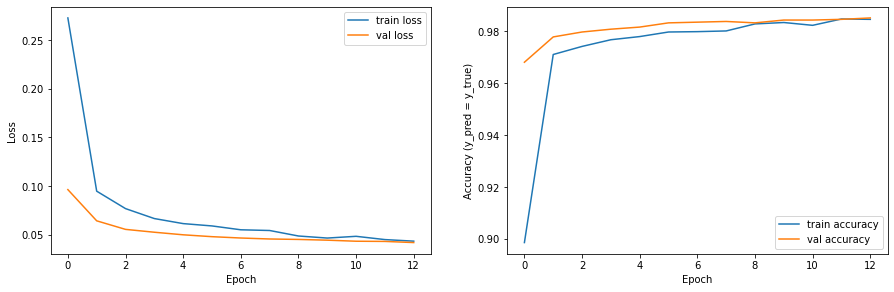

In [60]:
# plot loss vs epoch
plt.figure(figsize = (15,10))
axes = plt.subplot(2, 2, 1)
axes.plot(history.history['loss'], label = 'train loss')
axes.plot(history.history['val_loss'], label = 'val loss')
axes.legend(loc = "upper right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Loss')

# plot accuracy vs epoch
axes = plt.subplot(2, 2, 2)
axes.plot(history.history['accuracy'], label = 'train accuracy')
axes.plot(history.history['val_accuracy'], label = 'val accuracy')
axes.legend(loc = "lower right")
axes.set_xlabel('Epoch')
axes.set_ylabel('Accuracy (y_pred = y_true)')

## Partition the test set into sig/bkg sets

In [61]:
# test set
test_sig_number = np.count_nonzero(Y_test)
test_bkg_number = np.count_nonzero(Y_test == 0)

X_test_sig = np.zeros((test_sig_number,X_test.shape[1]))
X_test_bkg = np.zeros((test_bkg_number,X_test.shape[1]))

j = 0
k = 0
for i in range(Y_test.shape[0]):
    if Y_test[i,0] == 1:
        X_test_sig[j,:] = X_test[i,:]
        j = j + 1
    else:
        X_test_bkg[k,:] = X_test[i,:]
        k = k + 1

# train+val set
train_val_sig_number = np.count_nonzero(Y_train_val)
train_val_bkg_number = np.count_nonzero(Y_train_val == 0)

X_train_val_sig = np.zeros((train_val_sig_number,X_train_val.shape[1]))
X_train_val_bkg = np.zeros((train_val_bkg_number,X_train_val.shape[1]))

j = 0
k = 0
for i in range(Y_train_val.shape[0]):
    if Y_train_val[i,0] == 1:
        X_train_val_sig[j,:] = X_train_val[i,:]
        j = j + 1
    else:
        X_train_val_bkg[k,:] = X_train_val[i,:]
        k = k + 1

## Test set performance plots

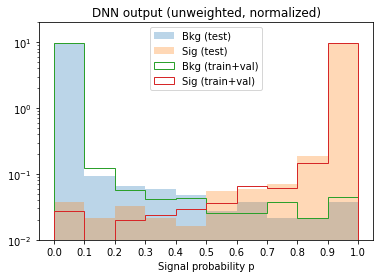

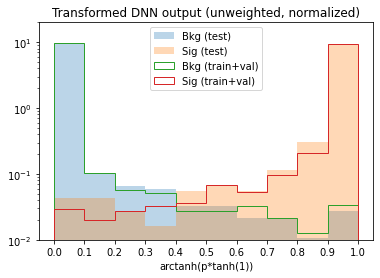

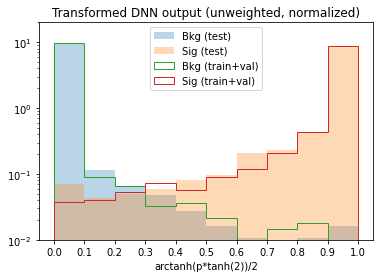

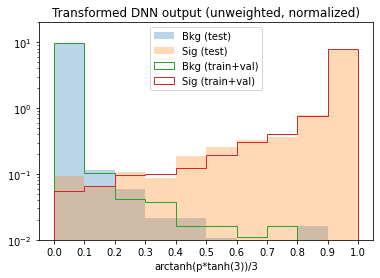

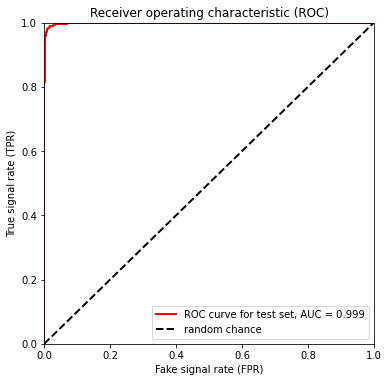

Test loss, test accuracy: [0.043144444517012735, 0.986193835735321]


In [62]:
#pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(model.predict(X_test_bkg), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(model.predict(X_test_sig), density = 1, range = (0.0, 1.0), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(model.predict(X_train_val_bkg), density = 1, range = (0.0, 1.0), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(model.predict(X_train_val_sig), density = 1, range = (0.0, 1.0), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('DNN output (unweighted, normalized)')
pyplot.xlabel('Signal probability p')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,2e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(1)), density = 1, range = (0.0, 1), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(1))')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,2e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(2))/2, density = 1, range = (0.0, 1), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(2))/2')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,2e1)
pyplot.show()

#pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)')
pyplot.hist(np.arctanh(model.predict(X_test_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Bkg (test)', log = True)
pyplot.hist(np.arctanh(model.predict(X_test_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, alpha = 0.3, label = 'Sig (test)')
pyplot.hist(np.arctanh(model.predict(X_train_val_bkg)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, label = 'Bkg (train+val)', histtype = 'step')
pyplot.hist(np.arctanh(model.predict(X_train_val_sig)*np.tanh(3))/3, density = 1, range = (0.0, 1), bins = 10, label = 'Sig (train+val)', histtype = 'step')
pyplot.legend(loc = 'upper center')
pyplot.title('Transformed DNN output (unweighted, normalized)')
pyplot.xlabel('arctanh(p*tanh(3))/3')
pyplot.xticks(np.arange(0, 1.1, step = 0.1))
pyplot.ylim(1e-2,2e1)
pyplot.show()

# Plot ROC
plt.figure(figsize = (13,13))
Y_predict = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
axes = plt.subplot(2, 2, 1)
axes.plot(fpr, tpr, lw = 2, color = 'red', label = 'ROC curve for test set, AUC = %.3f' % (roc_auc))
axes.plot([0, 1], [0, 1], linestyle = '--', lw = 2, color = 'black', label = 'random chance')
axes.set_xlim([0, 1.0])
axes.set_ylim([0, 1.0])
axes.set_xlabel('Fake signal rate (FPR)')
axes.set_ylabel('True signal rate (TPR)')
axes.set_title('Receiver operating characteristic (ROC)')
axes.legend(loc = "lower right")
plt.show()

results = model.evaluate(X_test, Y_test, verbose = 0, batch_size = 128)
print("Test loss, test accuracy:", results)

## Save trained model

In [63]:
joblib.dump(scaler, 'trained_models/em2b_scaler.gz')
model.save('trained_models/em2b_model')

## Load saved model

In [ ]:
savedscaler = joblib.load('trained_models/em2b_scaler.gz')
savedmodel = keras.models.load_model('trained_models/em2b_model')
savedmodel.summary()

# Write model prediction to root files

## Load all root files one by one

In [64]:
from root_numpy import array2root

########### 2018
infolder18 = 'root_raw/em18_raw/'
outfolder18 = 'root_outputs/em18_outputs/'

inpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths18 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3LNu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths18)):
    inpaths18[i] = infolder18 + inpaths18[i]
    outpaths18[i] = outfolder18 + outpaths18[i]

allfiles18 = []
for i in range(len(inpaths18)):
    allfiles18.append(ROOT.RDataFrame('emu_tree', inpaths18[i]))


for i in range(len(allfiles18)):
    allfiles18[i] = allfiles18[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbmu', m_bbmu)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2017
infolder17 = 'root_raw/em17_raw/'
outfolder17 = 'root_outputs/em17_outputs/'

inpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt12.root', 'ggH_bbtt20.root', 'ggH_bbtt30.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt50.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt12.root', 'vbf_bbtt20.root', 'vbf_bbtt30.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt50.root', 'vbf_bbtt60.root']

outpaths17 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TTTo2L2Nu.root', 'TTToHadronic.root', 'TTToSemiLeptonic.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'gghbbtt12.root', 'gghbbtt20.root', 'gghbbtt30.root', 'gghbbtt40.root'\
         , 'gghbbtt50.root', 'gghbbtt60.root', 'ttHnonbb.root'\
         , 'vbfbbtt12.root', 'vbfbbtt20.root', 'vbfbbtt30.root', 'vbfbbtt40.root'\
         , 'vbfbbtt50.root', 'vbfbbtt60.root']

for i in range(len(inpaths17)):
    inpaths17[i] = infolder17 + inpaths17[i]
    outpaths17[i] = outfolder17 + outpaths17[i]

allfiles17 = []
for i in range(len(inpaths17)):
    allfiles17.append(ROOT.RDataFrame('emu_tree', inpaths17[i]))


for i in range(len(allfiles17)):
    allfiles17[i] = allfiles17[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbmu', m_bbmu)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

########### 2016
infolder16 = 'root_raw/em16_raw/'
outfolder16 = 'root_outputs/em16_outputs/'

inpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

outpaths16 = ['DY.root', 'DY1.root', 'DY2.root', 'DY3.root', 'DY4.root'\
         , 'GGHTT.root', 'GGHWW.root', 'GGZHLLTT.root', 'GGZHNNTT.root'\
         , 'GGZHQQTT.root', 'GGZHWW.root', 'ST_tW_antitop.root'\
         , 'ST_tW_top.root', 'ST_t_antitop.root', 'ST_t_top.root'\
         , 'TT.root', 'VBFHTT.root', 'VBFHWW.root', 'VV2L2Nu.root'\
         , 'WZ2L2Q.root', 'WZ3L1Nu.root', 'WminusHTT.root', 'WminusHWW.root'\
         , 'WplusHTT.root', 'WplusHWW.root', 'ZHTT.root', 'ZHWW.root'\
         , 'ZZ2L2Q.root', 'ZZ4L.root', 'data_obs.root', 'embedded.root'\
         , 'ggH_bbtt15.root', 'ggH_bbtt20.root', 'ggH_bbtt25.root', 'ggH_bbtt30.root', 'ggH_bbtt35.root', 'ggH_bbtt40.root'\
         , 'ggH_bbtt45.root', 'ggH_bbtt50.root', 'ggH_bbtt55.root', 'ggH_bbtt60.root', 'ttHnonbb.root'\
         , 'vbf_bbtt15.root', 'vbf_bbtt20.root', 'vbf_bbtt25.root', 'vbf_bbtt30.root', 'vbf_bbtt35.root', 'vbf_bbtt40.root'\
         , 'vbf_bbtt45.root', 'vbf_bbtt50.root', 'vbf_bbtt55.root', 'vbf_bbtt60.root']

for i in range(len(inpaths16)):
    inpaths16[i] = infolder16 + inpaths16[i]
    outpaths16[i] = outfolder16 + outpaths16[i]

allfiles16 = []
for i in range(len(inpaths16)):
    allfiles16.append(ROOT.RDataFrame('emu_tree', inpaths16[i]))


for i in range(len(allfiles16)):
    allfiles16[i] = allfiles16[i].Define('myele', myele)\
    .Define('mymu', mymu)\
    .Define('mymet', mymet)\
    .Define('mytt', mytt)\
    .Define('myb1', myb1)\
    .Define('myb2', myb2)\
    .Define('m_b1tt', m_b1tt)\
    .Define('m_b2tt', m_b2tt)\
    .Define('m_bbtt', m_bbtt)\
    .Define('m_bb', m_bb)\
    .Define('m_b1ele', m_b1ele)\
    .Define('m_b1mu', m_b1mu)\
    .Define('m_b2ele', m_b2ele)\
    .Define('m_b2mu', m_b2mu)\
    .Define('m_bbele', m_bbele)\
    .Define('m_bbmu', m_bbmu)\
    .Define('dm_a', dm_a)\
    .Define('dR_tt', dR_tt)\
    .Define('dR_b1ele', dR_b1ele)\
    .Define('dR_b1mu', dR_b1mu)\
    .Define('dR_b2ele', dR_b2ele)\
    .Define('dR_b2mu', dR_b2mu)\
    .Define('dR_bb', dR_bb)\
    .Define('dR_b1tt', dR_b1tt)\
    .Define('dR_b2tt', dR_b2tt)\
    .Define('dR_aa', dR_aa)\
    .Define('dR_bbele', dR_bbele)\
    .Define('dR_bbmu', dR_bbmu)\
    .Define('mT_ele', mT_ele)\
    .Define('mT_mu', mT_mu)\
    .Define('mT_b1', mT_b1)\
    .Define('mT_b2', mT_b2)\
    .Define('norm_zeta', norm_zeta)\
    .Define('x_zeta', x_zeta)\
    .Define('y_zeta', y_zeta)\
    .Define('p_zeta_mis', p_zeta_mis)\
    .Define('pzeta_vis', pzeta_vis)\
    .Define('Dzeta', Dzeta)

## Data pre-processing

In [65]:
######### 2018
for i in range(len(allfiles18)):
    allfiles18[i] = pd.DataFrame(allfiles18[i].AsNumpy(feature_list))
    allfiles18[i] = allfiles18[i].values
    allfiles18[i] = scaler.transform(allfiles18[i])
    print(inpaths18[i])

root_raw/em18_raw/DY.root
root_raw/em18_raw/DY1.root
root_raw/em18_raw/DY2.root
root_raw/em18_raw/DY3.root
root_raw/em18_raw/DY4.root
root_raw/em18_raw/GGHTT.root
root_raw/em18_raw/GGHWW.root
root_raw/em18_raw/GGZHLLTT.root
root_raw/em18_raw/GGZHNNTT.root
root_raw/em18_raw/GGZHQQTT.root
root_raw/em18_raw/GGZHWW.root
root_raw/em18_raw/ST_tW_antitop.root
root_raw/em18_raw/ST_tW_top.root
root_raw/em18_raw/ST_t_antitop.root
root_raw/em18_raw/ST_t_top.root
root_raw/em18_raw/TTTo2L2Nu.root
root_raw/em18_raw/TTToHadronic.root
root_raw/em18_raw/TTToSemiLeptonic.root
root_raw/em18_raw/VBFHTT.root
root_raw/em18_raw/VBFHWW.root
root_raw/em18_raw/VV2L2Nu.root
root_raw/em18_raw/WZ2L2Q.root
root_raw/em18_raw/WZ3LNu.root
root_raw/em18_raw/WminusHTT.root
root_raw/em18_raw/WminusHWW.root
root_raw/em18_raw/WplusHTT.root
root_raw/em18_raw/WplusHWW.root
root_raw/em18_raw/ZHTT.root
root_raw/em18_raw/ZHWW.root
root_raw/em18_raw/ZZ2L2Q.root
root_raw/em18_raw/ZZ4L.root
root_raw/em18_raw/data_obs.root
root_raw

In [67]:
######### 2017
for i in range(len(allfiles17)):
    allfiles17[i] = pd.DataFrame(allfiles17[i].AsNumpy(feature_list))
    allfiles17[i] = allfiles17[i].values
    allfiles17[i] = scaler.transform(allfiles17[i])
    print(inpaths17[i])

root_raw/em17_raw/DY.root
root_raw/em17_raw/DY1.root
root_raw/em17_raw/DY2.root
root_raw/em17_raw/DY3.root
root_raw/em17_raw/DY4.root
root_raw/em17_raw/GGHTT.root
root_raw/em17_raw/GGHWW.root
root_raw/em17_raw/GGZHLLTT.root
root_raw/em17_raw/GGZHNNTT.root
root_raw/em17_raw/GGZHQQTT.root
root_raw/em17_raw/GGZHWW.root
root_raw/em17_raw/ST_tW_antitop.root
root_raw/em17_raw/ST_tW_top.root
root_raw/em17_raw/ST_t_antitop.root
root_raw/em17_raw/ST_t_top.root
root_raw/em17_raw/TTTo2L2Nu.root
root_raw/em17_raw/TTToHadronic.root
root_raw/em17_raw/TTToSemiLeptonic.root
root_raw/em17_raw/VBFHTT.root
root_raw/em17_raw/VBFHWW.root
root_raw/em17_raw/VV2L2Nu.root
root_raw/em17_raw/WZ2L2Q.root
root_raw/em17_raw/WZ3L1Nu.root
root_raw/em17_raw/WminusHTT.root
root_raw/em17_raw/WminusHWW.root
root_raw/em17_raw/WplusHTT.root
root_raw/em17_raw/WplusHWW.root
root_raw/em17_raw/ZHTT.root
root_raw/em17_raw/ZHWW.root
root_raw/em17_raw/ZZ2L2Q.root
root_raw/em17_raw/ZZ4L.root
root_raw/em17_raw/data_obs.root
root_ra

In [69]:
######### 2016
for i in range(len(allfiles16)):
    allfiles16[i] = pd.DataFrame(allfiles16[i].AsNumpy(feature_list))
    allfiles16[i] = allfiles16[i].values
    allfiles16[i] = scaler.transform(allfiles16[i])
    print(inpaths16[i])

root_raw/em16_raw/DY.root
root_raw/em16_raw/DY1.root
root_raw/em16_raw/DY2.root
root_raw/em16_raw/DY3.root
root_raw/em16_raw/DY4.root
root_raw/em16_raw/GGHTT.root
root_raw/em16_raw/GGHWW.root
root_raw/em16_raw/GGZHLLTT.root
root_raw/em16_raw/GGZHNNTT.root
root_raw/em16_raw/GGZHQQTT.root
root_raw/em16_raw/GGZHWW.root
root_raw/em16_raw/ST_tW_antitop.root
root_raw/em16_raw/ST_tW_top.root
root_raw/em16_raw/ST_t_antitop.root
root_raw/em16_raw/ST_t_top.root
root_raw/em16_raw/TT.root
root_raw/em16_raw/VBFHTT.root
root_raw/em16_raw/VBFHWW.root
root_raw/em16_raw/VV2L2Nu.root
root_raw/em16_raw/WZ2L2Q.root
root_raw/em16_raw/WZ3L1Nu.root
root_raw/em16_raw/WminusHTT.root
root_raw/em16_raw/WminusHWW.root
root_raw/em16_raw/WplusHTT.root
root_raw/em16_raw/WplusHWW.root
root_raw/em16_raw/ZHTT.root
root_raw/em16_raw/ZHWW.root
root_raw/em16_raw/ZZ2L2Q.root
root_raw/em16_raw/ZZ4L.root
root_raw/em16_raw/data_obs.root
root_raw/em16_raw/embedded.root
root_raw/em16_raw/ggH_bbtt15.root
root_raw/em16_raw/ggH_bb

## Feed to NN and write outputs to root files

In [66]:
######### 2018
for i in range(len(allfiles18)):
    y_pred = model.predict(allfiles18[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths18[i], treename = 'emu_tree_dnn', mode = 'update')
    print(outpaths18[i])

root_outputs/em18_outputs/DY.root
root_outputs/em18_outputs/DY1.root
root_outputs/em18_outputs/DY2.root
root_outputs/em18_outputs/DY3.root
root_outputs/em18_outputs/DY4.root
root_outputs/em18_outputs/GGHTT.root
root_outputs/em18_outputs/GGHWW.root
root_outputs/em18_outputs/GGZHLLTT.root
root_outputs/em18_outputs/GGZHNNTT.root
root_outputs/em18_outputs/GGZHQQTT.root
root_outputs/em18_outputs/GGZHWW.root
root_outputs/em18_outputs/ST_tW_antitop.root
root_outputs/em18_outputs/ST_tW_top.root
root_outputs/em18_outputs/ST_t_antitop.root
root_outputs/em18_outputs/ST_t_top.root
root_outputs/em18_outputs/TTTo2L2Nu.root
root_outputs/em18_outputs/TTToHadronic.root
root_outputs/em18_outputs/TTToSemiLeptonic.root
root_outputs/em18_outputs/VBFHTT.root
root_outputs/em18_outputs/VBFHWW.root
root_outputs/em18_outputs/VV2L2Nu.root
root_outputs/em18_outputs/WZ2L2Q.root
root_outputs/em18_outputs/WZ3LNu.root
root_outputs/em18_outputs/WminusHTT.root
root_outputs/em18_outputs/WminusHWW.root
root_outputs/em18_

In [68]:
######### 2017
for i in range(len(allfiles17)):
    y_pred = model.predict(allfiles17[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths17[i], treename = 'emu_tree_dnn', mode = 'update')
    print(outpaths17[i])

root_outputs/em17_outputs/DY.root
root_outputs/em17_outputs/DY1.root
root_outputs/em17_outputs/DY2.root
root_outputs/em17_outputs/DY3.root
root_outputs/em17_outputs/DY4.root
root_outputs/em17_outputs/GGHTT.root
root_outputs/em17_outputs/GGHWW.root
root_outputs/em17_outputs/GGZHLLTT.root
root_outputs/em17_outputs/GGZHNNTT.root
root_outputs/em17_outputs/GGZHQQTT.root
root_outputs/em17_outputs/GGZHWW.root
root_outputs/em17_outputs/ST_tW_antitop.root
root_outputs/em17_outputs/ST_tW_top.root
root_outputs/em17_outputs/ST_t_antitop.root
root_outputs/em17_outputs/ST_t_top.root
root_outputs/em17_outputs/TTTo2L2Nu.root
root_outputs/em17_outputs/TTToHadronic.root
root_outputs/em17_outputs/TTToSemiLeptonic.root
root_outputs/em17_outputs/VBFHTT.root
root_outputs/em17_outputs/VBFHWW.root
root_outputs/em17_outputs/VV2L2Nu.root
root_outputs/em17_outputs/WZ2L2Q.root
root_outputs/em17_outputs/WZ3L1Nu.root
root_outputs/em17_outputs/WminusHTT.root
root_outputs/em17_outputs/WminusHWW.root
root_outputs/em17

In [70]:
######### 2016
for i in range(len(allfiles16)):
    y_pred = model.predict(allfiles16[i])
    y_pred = np.array(y_pred, dtype = [('dnn_2b', np.float32)])
    array2root(y_pred, filename = outpaths16[i], treename = 'emu_tree_dnn', mode = 'update')
    print(outpaths16[i])

root_outputs/em16_outputs/DY.root
root_outputs/em16_outputs/DY1.root
root_outputs/em16_outputs/DY2.root
root_outputs/em16_outputs/DY3.root
root_outputs/em16_outputs/DY4.root
root_outputs/em16_outputs/GGHTT.root
root_outputs/em16_outputs/GGHWW.root
root_outputs/em16_outputs/GGZHLLTT.root
root_outputs/em16_outputs/GGZHNNTT.root
root_outputs/em16_outputs/GGZHQQTT.root
root_outputs/em16_outputs/GGZHWW.root
root_outputs/em16_outputs/ST_tW_antitop.root
root_outputs/em16_outputs/ST_tW_top.root
root_outputs/em16_outputs/ST_t_antitop.root
root_outputs/em16_outputs/ST_t_top.root
root_outputs/em16_outputs/TT.root
root_outputs/em16_outputs/VBFHTT.root
root_outputs/em16_outputs/VBFHWW.root
root_outputs/em16_outputs/VV2L2Nu.root
root_outputs/em16_outputs/WZ2L2Q.root
root_outputs/em16_outputs/WZ3L1Nu.root
root_outputs/em16_outputs/WminusHTT.root
root_outputs/em16_outputs/WminusHWW.root
root_outputs/em16_outputs/WplusHTT.root
root_outputs/em16_outputs/WplusHWW.root
root_outputs/em16_outputs/ZHTT.root
